<a href="https://colab.research.google.com/github/Huda-AbuZayed/Chicago_Crimes_Time_Series_Analysis_and_Forecasting/blob/main/Chicago_Crime_Data_Huda_AbuZayed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 3 part 1: Chicago Crime Data**

**Name: Huda AbuZayed**

This Project is for preparing a crime dataset for time series analysis.And then use it to answer the provided stakeholder questions and support our answers with visualizations.

* Original Source: Chicago Data Portal: Crimes 2001 to Present.
* Data Description: All Crimes that were reported in the city of Chicago and their details (https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/data)
* Includes:
type of crime, exact date/time, lat/long, District/ward, was there an arrest, etc.


# Importing Libraries

In [ ]:
!pip install holidays
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import statsmodels.tsa.api as tsa
from scipy.signal import find_peaks
import holidays
import datetime as dt
from holidays import country_holidays
import statsmodels.tsa.api as tsa
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")
## Setting figures to timeseries-friendly
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)
# set random seed
SEED = 321
np.random.seed(SEED)
#display more columns
pd.set_option('display.max_columns',50)

# Custom Functions

In [ ]:
def format_xdates(ax, fig=None, xtick_fontweight='bold',
               title= None):
    """Formats x-axis with minor ticks every 3 months, and major
    ticks every year. Includes different grid options for visibility"""
    # create the locator to place ticks every 3 months.
    loc_3months = mdates.MonthLocator(interval=3)
    fmt_months = mdates.DateFormatter("%b")
    ## for major year ticks
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")

    ## Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(),
                       fontweight=xtick_fontweight)

    ## customize minor ticks
    ax.xaxis.set_minor_locator(loc_3months)
    ax.xaxis.set_minor_formatter(fmt_months)
    ## customize major ticks
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    ## Making major/minor gridlines visually distince
    ax.grid(which='minor',axis='x',ls=":")
    ax.grid(which='major',axis='x',color='k')
    if fig is None:
        fig = ax.get_figure()
    ## rotate the dates
    fig.autofmt_xdate(which='major',rotation=90,ha='center')
    return fig,ax

In [ ]:
# This functions to format money in millions and in thousands
def millions(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000_000
    return f"{new_x:,.0f}M"
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

In [ ]:
## we've done enough customization that it makes sense to bundle this in a function
def plot_dates(ts,figsize=(12,4),xtick_fontsize='large', xtick_fontweight='bold',
               title= None):## Make the fig and axis first

    if title is None:
        title = ts.name
    # plot the time series with pandas
    fig, ax = plt.subplots(figsize=figsize)
    ts.plot(ax=ax,title=title);

    ## creating our tick locators and formatters
    ## for minor month ticks
    # create the locator to place ticks every 3 months.
    loc_3months = mdates.MonthLocator(interval=3)
    fmt_months = mdates.DateFormatter("%b")
    ## for major year ticks
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")

    ## Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(),
                       fontsize=xtick_fontsize,
                       fontweight=xtick_fontweight)

    ## customize minor ticks
    ax.xaxis.set_minor_locator(loc_3months)
    ax.xaxis.set_minor_formatter(fmt_months)
    ## customize major ticks
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    ## Making major/minor gridlines visually distinct
    ax.grid(which='minor',axis='x',ls=":")
    ax.grid(which='major',axis='x',color='k')
    ## rotate the dates
    fig.autofmt_xdate(which='major',rotation=90,ha='center')
    return fig,ax

In [ ]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();

    return fig, ax

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    #rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    rmse = np.sqrt(mse)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100
    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")
    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    #rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    rmse = np.sqrt(mse)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100
    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")
    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [ ]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        '# of Lags Used':nlags,
                        '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])


In [ ]:
def get_sig_lags(ts, type='ACF',  nlags=None,alpha=0.5):


    if type == 'ACF':
        # Running the function used by plot_acf
        corr_values, conf_int = tsa.stattools.acf(ts, alpha=alpha, nlags=nlags)

    elif type=='PACF':
        corr_values, conf_int = tsa.stattools.pacf(ts, alpha=alpha, nlags=nlags)

    else:
        raise Exception("type must be either 'ACF' or 'PACF'")

    # Determine lags
    lags =range(len(corr_values))

    # Create a centered version of the acf_df
    corr_df = pd.DataFrame({type:corr_values,
                            'Lags':lags,
                            'lower ci': conf_int[:,0]-corr_values, # subtract acf from lower ci to center
                            'upper ci': conf_int[:,1]-corr_values, # subtact acf to upper ci to center
                                 })
    corr_df = corr_df.set_index("Lags")

    # Getting filter for sig lags
    filter_sig_lags = (corr_df[type] < corr_df['lower ci']) | (corr_df[type] > corr_df['upper ci'])

    # Get lag #'s
    sig_lags= corr_df.index[filter_sig_lags]
    sig_lags = sig_lags[sig_lags!=0]

    return sig_lags



In [ ]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)


    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)




    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig



# Load the data

In [ ]:
import zipfile

In [ ]:
!pip install zipfile36
import pandas as pd
import zipfile

# Define the path to your zip file
fpath = '/content/drive/MyDrive/codingDojo/CodingDojo/04-DataViz/Chicago_Crime_2001-2022.zip'

# Create a ZipFile object
with zipfile.ZipFile(fpath, 'r') as zip_ref:
    # Get a list of all files in the zip archive
    all_files = zip_ref.namelist()

    # Filter the list to find the CSV files (you might need to adjust the pattern based on your file names)
    csv_files = [f for f in all_files if f.endswith('.csv')]

    # Create an empty list to store the dataframes
    dfs = []

    # Loop through the CSV files and read them into pandas dataframes
    for file in csv_files:
        with zip_ref.open(file) as f:
            # Read the CSV file into a dataframe, assuming the first row contains column names
            df = pd.read_csv(f) # Remove .drop(columns="Unnamed: 0") if it's not consistently present in all CSV files within the zip.

            # Append the dataframe to the list
            dfs.append(df)

# Concatenate all dataframes into a single dataframe
df = pd.concat(dfs, ignore_index=True)

# Now you can work with the combined dataframe 'df'
# Example: print some info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7713109 entries, 0 to 7713108
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 603.2+ MB


In [ ]:
df.head()

ID                    Date     Primary Type          Description  \
0  1326041  01/01/2001 01:00:00 AM          BATTERY               SIMPLE   
1  1319931  01/01/2001 01:00:00 PM          BATTERY               SIMPLE   
2  1324743  01/01/2001 01:00:00 PM         GAMBLING  ILLEGAL ILL LOTTERY   
3  1310717  01/01/2001 01:00:00 AM  CRIMINAL DAMAGE           TO VEHICLE   
4  1318099  01/01/2001 01:00:00 AM          BATTERY               SIMPLE   

      Location Description  Arrest  Domestic  Beat  District  Ward   Latitude  \
0                RESIDENCE   False     False  1624      16.0   NaN  41.957850   
1                RESIDENCE   False      True   825       8.0   NaN  41.783892   
2                   STREET    True     False   313       3.0   NaN  41.780412   
3                   STREET   False     False  2424      24.0   NaN  42.012391   
4  RESIDENCE PORCH/HALLWAY   False      True   214       2.0   NaN  41.819538   

   Longitude  
0 -87.749185  
1 -87.684841  
2 -87.611970  
3 -87.678032  
4 -87.620020

# Data Cleaning / Timeseries Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7713109 entries, 0 to 7713108
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 603.2+ MB


In [ ]:
df.head(10)

ID                    Date                Primary Type  \
0  1326041  01/01/2001 01:00:00 AM                     BATTERY   
1  1319931  01/01/2001 01:00:00 PM                     BATTERY   
2  1324743  01/01/2001 01:00:00 PM                    GAMBLING   
3  1310717  01/01/2001 01:00:00 AM             CRIMINAL DAMAGE   
4  1318099  01/01/2001 01:00:00 AM                     BATTERY   
5  5462733  01/01/2001 01:00:00 AM  OFFENSE INVOLVING CHILDREN   
6  1311626  01/01/2001 01:00:00 AM             CRIMINAL DAMAGE   
7  1311123  01/01/2001 01:00:00 AM             CRIMINAL DAMAGE   
8  1310586  01/01/2001 01:00:00 AM                       THEFT   
9  1311269  01/01/2001 01:00:00 AM             CRIMINAL DAMAGE   

                     Description     Location Description  Arrest  Domestic  \
0                         SIMPLE                RESIDENCE   False     False   
1                         SIMPLE                RESIDENCE   False      True   
2            ILLEGAL ILL LOTTERY                   STREET    True     False   
3                     TO VEHICLE                   STREET   False     False   
4                         SIMPLE  RESIDENCE PORCH/HALLWAY   False      True   
5  AGG CRIM SEX ABUSE FAM MEMBER                RESIDENCE   False      True   
6                     TO VEHICLE                   STREET   False     False   
7                     TO VEHICLE                   STREET   False     False   
8                 $500 AND UNDER                   STREET   False     False   
9                    TO PROPERTY                RESIDENCE   False     False   

   Beat  District  Ward   Latitude  Longitude  
0  1624      16.0   NaN  41.957850 -87.749185  
1   825       8.0   NaN  41.783892 -87.684841  
2   313       3.0   NaN  41.780412 -87.611970  
3  2424      24.0   NaN  42.012391 -87.678032  
4   214       2.0   NaN  41.819538 -87.620020  
5   233       2.0  20.0  41.789084 -87.620849  
6  1033      10.0   NaN  41.848786 -87.704087  
7  1223      12.0   NaN  41.854014 -87.681909  
8   911       9.0   NaN  41.798298 -87.692856  
9   421       4.0   NaN  41.756690 -87.561625

In [ ]:
#check the duplicates
df.duplicated().sum()

0

In [ ]:
# define which columns we want to drop
# first display the columns
df.columns

Index(['ID', 'Date', 'Primary Type', 'Description', 'Location Description',
       'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Latitude',
       'Longitude'],
      dtype='object')

In [ ]:
df = df.drop(columns = ['ID','Ward','Latitude', 'Longitude'])


# Handling Inconsistencies

In [ ]:
cat_cols = df.select_dtypes(include = 'object')

In [ ]:
for col in cat_cols:
    print(f"Value Counts for {col}")
    print(df[col].value_counts())
    # Increasing readability by adding an empty line
    print('\n')

Value Counts for Date
Date
01/01/2008 12:01:00 AM    304
01/01/2007 12:01:00 AM    259
01/01/2006 12:01:00 AM    226
01/01/2004 12:00:00 AM    218
01/01/2005 12:01:00 AM    215
                         ... 
05/13/2010 07:31:00 PM      1
04/23/2004 11:40:00 AM      1
05/13/2010 07:28:00 PM      1
05/13/2010 07:25:00 PM      1
12/31/2022 12:59:00 PM      1
Name: count, Length: 3172250, dtype: int64


Value Counts for Primary Type
Primary Type
THEFT                                1626992
BATTERY                              1410889
CRIMINAL DAMAGE                       878914
NARCOTICS                             746155
ASSAULT                               501103
OTHER OFFENSE                         479174
BURGLARY                              422246
MOTOR VEHICLE THEFT                   366586
DECEPTIVE PRACTICE                    340958
ROBBERY                               289677
CRIMINAL TRESPASS                     212869
WEAPONS VIOLATION                     103906
PROSTITUTION   

As we can see above the Primary Type column has inconsistent values.  

In [ ]:
df['Primary Type'] = df['Primary Type'].replace(['NON - CRIMINAL', 'NON-CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)'], 'NON-CRIMINAL')
df['Primary Type'] = df['Primary Type'].replace(['CRIM SEXUAL ASSAULT','SEX OFFENSE','PROSTITUTION','CRIMINAL SEXUAL ASSAULT'],'Sexual Crime')
df['Primary Type'].value_counts()

Primary Type
THEFT                                1626992
BATTERY                              1410889
CRIMINAL DAMAGE                       878914
NARCOTICS                             746155
ASSAULT                               501103
OTHER OFFENSE                         479174
BURGLARY                              422246
MOTOR VEHICLE THEFT                   366586
DECEPTIVE PRACTICE                    340958
ROBBERY                               289677
CRIMINAL TRESPASS                     212869
Sexual Crime                          134129
WEAPONS VIOLATION                     103906
OFFENSE INVOLVING CHILDREN             55280
PUBLIC PEACE VIOLATION                 52086
INTERFERENCE WITH PUBLIC OFFICER       18206
LIQUOR LAW VIOLATION                   14846
GAMBLING                               14616
ARSON                                  13121
HOMICIDE                               12394
KIDNAPPING                              7185
STALKING                                4664
INTIMIDATION                            4595
CONCEALED CARRY LICENSE VIOLATION       1019
OBSCENITY                                810
NON-CRIMINAL                             228
PUBLIC INDECENCY                         193
OTHER NARCOTIC VIOLATION                 147
HUMAN TRAFFICKING                         96
RITUALISM                                 24
DOMESTIC VIOLENCE                          1
Name: count, dtype: int64

# Handling Null Values

In [ ]:
df.isna().sum()

Date                        0
Primary Type                0
Description                 0
Location Description    10928
Arrest                      0
Domestic                    0
Beat                        0
District                   47
dtype: int64

In [ ]:
df.isnull().sum() * 100 / len(df)

Date                    0.000000
Primary Type            0.000000
Description             0.000000
Location Description    0.141681
Arrest                  0.000000
Domestic                0.000000
Beat                    0.000000
District                0.000609
dtype: float64

There are null values in columns Location Description and District

In [ ]:
df[df['Location Description'].isna()]

Date        Primary Type  \
94769    03/18/2001 09:37:10 PM             BATTERY   
100552   03/22/2001 12:30:00 AM  DECEPTIVE PRACTICE   
341641   09/12/2001 11:10:00 AM  DECEPTIVE PRACTICE   
368478   10/02/2001 04:30:00 PM  DECEPTIVE PRACTICE   
454496   12/05/2001 02:45:00 PM  DECEPTIVE PRACTICE   
...                         ...                 ...   
7711951  12/30/2022 05:02:00 PM  DECEPTIVE PRACTICE   
7712118  12/30/2022 09:00:00 AM  DECEPTIVE PRACTICE   
7712146  12/30/2022 09:20:00 AM  DECEPTIVE PRACTICE   
7712248  12/30/2022 11:05:00 PM  DECEPTIVE PRACTICE   
7712545  12/31/2022 03:35:00 PM  DECEPTIVE PRACTICE   

                                     Description Location Description  Arrest  \
94769                                     SIMPLE                  NaN   False   
100552             STOLEN PROP: BUY/RECEIVE/POS.                  NaN    True   
341641       FINANCIAL IDENTITY THEFT OVER $ 300                  NaN   False   
368478       FINANCIAL IDENTITY THEFT OVER $ 300                  NaN   False   
454496       FINANCIAL IDENTITY THEFT OVER $ 300                  NaN   False   
...                                          ...                  ...     ...   
7711951  FINANCIAL IDENTITY THEFT $300 AND UNDER                  NaN   False   
7712118      FINANCIAL IDENTITY THEFT OVER $ 300                  NaN   False   
7712146      FINANCIAL IDENTITY THEFT OVER $ 300                  NaN   False   
7712248      FINANCIAL IDENTITY THEFT OVER $ 300                  NaN   False   
7712545      FINANCIAL IDENTITY THEFT OVER $ 300                  NaN   False   

         Domestic  Beat  District  
94769       False  1031      10.0  
100552      False  1924      19.0  
341641      False   111       1.0  
368478      False   434       4.0  
454496      False   412       4.0  
...           ...   ...       ...  
7711951     False  1133      11.0  
7712118     False  2423      24.0  
7712146     False  1922      19.0  
7712248     False  1932      19.0  
7712545     False  1934      19.0  

[10928 rows x 8 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7713109 entries, 0 to 7713108
Data columns (total 8 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Date                  object 
 1   Primary Type          object 
 2   Description           object 
 3   Location Description  object 
 4   Arrest                bool   
 5   Domestic              bool   
 6   Beat                  int64  
 7   District              float64
dtypes: bool(2), float64(1), int64(1), object(4)
memory usage: 367.8+ MB


In [ ]:
df['Location Description'].describe()

count     7702181
unique        215
top        STREET
freq      2005166
Name: Location Description, dtype: object

In [ ]:
df.describe()

Beat      District
count  7.713109e+06  7.713062e+06
mean   1.186294e+03  1.129533e+01
std    7.030648e+02  6.951157e+00
min    1.110000e+02  1.000000e+00
25%    6.210000e+02  6.000000e+00
50%    1.034000e+03  1.000000e+01
75%    1.731000e+03  1.700000e+01
max    2.535000e+03  3.100000e+01

The most frequent value in Location Description column is "STREET" so we wil fill the null value in this column by it

In [ ]:
df['Location Description'] = df['Location Description'].fillna(value = 'STREET')

In [ ]:
df['Location Description'].isna().sum()

0

In [ ]:
df['District'].describe()

count    7.713062e+06
mean     1.129533e+01
std      6.951157e+00
min      1.000000e+00
25%      6.000000e+00
50%      1.000000e+01
75%      1.700000e+01
max      3.100000e+01
Name: District, dtype: float64

In [ ]:
District_mean = df['District'].mean()
df['District'] = df['District'].fillna(District_mean)

In [ ]:
df['District'].isna().sum()

0

In [ ]:
df.isna().sum()

Date                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
dtype: int64

# Time Series Preprocessing

The task is to answer a series of questions about trends in crimes in Chicago for a reporter for the local newspaper.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'],errors='coerce')

In [ ]:
df = df.set_index('Date')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7713109 entries, 2001-01-01 01:00:00 to 2022-12-31 12:59:00
Data columns (total 7 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Primary Type          object 
 1   Description           object 
 2   Location Description  object 
 3   Arrest                bool   
 4   Domestic              bool   
 5   Beat                  int64  
 6   District              float64
dtypes: bool(2), float64(1), int64(1), object(3)
memory usage: 367.8+ MB


In [ ]:
df.tail(10)

Primary Type  \
Date                                      
2022-12-31 12:41:00       OTHER OFFENSE   
2022-12-31 00:42:00       OTHER OFFENSE   
2022-12-31 00:44:00             BATTERY   
2022-12-31 00:45:00   CRIMINAL TRESPASS   
2022-12-31 12:45:00     CRIMINAL DAMAGE   
2022-12-31 12:50:00             ASSAULT   
2022-12-31 12:50:00             ASSAULT   
2022-12-31 00:52:00             BATTERY   
2022-12-31 12:52:00             ASSAULT   
2022-12-31 12:59:00  DECEPTIVE PRACTICE   

                                                 Description  \
Date                                                           
2022-12-31 12:41:00       GUN OFFENDER - ANNUAL REGISTRATION   
2022-12-31 00:42:00                    OTHER VEHICLE OFFENSE   
2022-12-31 00:44:00      AGGRAVATED - OTHER DANGEROUS WEAPON   
2022-12-31 00:45:00                                  TO LAND   
2022-12-31 12:45:00                              TO PROPERTY   
2022-12-31 12:50:00                                   SIMPLE   
2022-12-31 12:50:00                     AGGRAVATED - HANDGUN   
2022-12-31 00:52:00                                   SIMPLE   
2022-12-31 12:52:00                                   SIMPLE   
2022-12-31 12:59:00  FINANCIAL IDENTITY THEFT $300 AND UNDER   

                             Location Description  Arrest  Domestic  Beat  \
Date                                                                        
2022-12-31 12:41:00                        STREET    True     False   412   
2022-12-31 00:42:00                     APARTMENT   False      True   213   
2022-12-31 00:44:00   RESIDENCE - PORCH / HALLWAY   False     False  1915   
2022-12-31 00:45:00                    RESTAURANT   False     False   322   
2022-12-31 12:45:00            SMALL RETAIL STORE   False     False  1131   
2022-12-31 12:50:00                     APARTMENT   False     False  1014   
2022-12-31 12:50:00                     APARTMENT   False      True   733   
2022-12-31 00:52:00                    BARBERSHOP   False     False  1135   
2022-12-31 12:52:00  COMMERCIAL / BUSINESS OFFICE   False     False  1432   
2022-12-31 12:59:00                     RESIDENCE   False     False  1511   

                     District  
Date                           
2022-12-31 12:41:00       4.0  
2022-12-31 00:42:00       2.0  
2022-12-31 00:44:00      19.0  
2022-12-31 00:45:00       3.0  
2022-12-31 12:45:00      11.0  
2022-12-31 12:50:00      10.0  
2022-12-31 12:50:00       7.0  
2022-12-31 00:52:00      11.0  
2022-12-31 12:52:00      14.0  
2022-12-31 12:59:00      15.0

In [ ]:
df = df.sort_index()
df.index

DatetimeIndex(['2001-01-01 00:00:00', '2001-01-01 00:00:00',
               '2001-01-01 00:00:00', '2001-01-01 00:00:00',
               '2001-01-01 00:00:00', '2001-01-01 00:00:00',
               '2001-01-01 00:00:00', '2001-01-01 00:00:00',
               '2001-01-01 00:00:00', '2001-01-01 00:00:00',
               ...
               '2022-12-31 23:45:00', '2022-12-31 23:45:00',
               '2022-12-31 23:45:00', '2022-12-31 23:45:00',
               '2022-12-31 23:45:00', '2022-12-31 23:47:00',
               '2022-12-31 23:47:00', '2022-12-31 23:50:00',
               '2022-12-31 23:50:00', '2022-12-31 23:55:00'],
              dtype='datetime64[ns]', name='Date', length=7713109, freq=None)

## Comparing Police Districts
* Which district had the most crimes in 2022?
* Which had the least?

In [ ]:
# creating new column for the year
df['year'] = df.index.year

In [ ]:
df.head(10)

Primary Type                    Description  \
Date                                                                    
2001-01-01                       THEFT  FINANCIAL ID THEFT: OVER $300   
2001-01-01                       THEFT        AGG: FINANCIAL ID THEFT   
2001-01-01  OFFENSE INVOLVING CHILDREN  SEX ASSLT OF CHILD BY FAM MBR   
2001-01-01                       THEFT  FINANCIAL ID THEFT: OVER $300   
2001-01-01                Sexual Crime      AGG CRIMINAL SEXUAL ABUSE   
2001-01-01             CRIMINAL DAMAGE                     TO VEHICLE   
2001-01-01                Sexual Crime      AGG CRIMINAL SEXUAL ABUSE   
2001-01-01                Sexual Crime      AGG CRIMINAL SEXUAL ABUSE   
2001-01-01                       THEFT  FINANCIAL ID THEFT: OVER $300   
2001-01-01                       THEFT  FINANCIAL ID THEFT: OVER $300   

                         Location Description  Arrest  Domestic  Beat  \
Date                                                                    
2001-01-01                             STREET   False     False  2221   
2001-01-01                          RESIDENCE   False     False   812   
2001-01-01                          RESIDENCE   False     False  2124   
2001-01-01                          RESIDENCE   False     False   915   
2001-01-01  CHURCH/SYNAGOGUE/PLACE OF WORSHIP   False     False  1022   
2001-01-01                              OTHER   False     False  2411   
2001-01-01                          RESIDENCE   False     False   422   
2001-01-01  CHURCH/SYNAGOGUE/PLACE OF WORSHIP   False     False  1022   
2001-01-01                          RESIDENCE   False     False  1132   
2001-01-01                          RESIDENCE   False     False  1021   

            District  year  
Date                        
2001-01-01      22.0  2001  
2001-01-01       8.0  2001  
2001-01-01       2.0  2001  
2001-01-01       9.0  2001  
2001-01-01      10.0  2001  
2001-01-01      24.0  2001  
2001-01-01       4.0  2001  
2001-01-01      10.0  2001  
2001-01-01      11.0  2001  
2001-01-01      10.0  2001

In [ ]:
df.tail()

Primary Type                    Description  \
Date                                                                      
2022-12-31 23:47:00              ASSAULT                         SIMPLE   
2022-12-31 23:47:00    WEAPONS VIOLATION  UNLAWFUL POSSESSION - HANDGUN   
2022-12-31 23:50:00              BATTERY        DOMESTIC BATTERY SIMPLE   
2022-12-31 23:50:00  MOTOR VEHICLE THEFT                     AUTOMOBILE   
2022-12-31 23:55:00    WEAPONS VIOLATION     RECKLESS FIREARM DISCHARGE   

                                Location Description  Arrest  Domestic  Beat  \
Date                                                                           
2022-12-31 23:47:00                           STREET    True     False  2221   
2022-12-31 23:47:00                        APARTMENT    True     False  2221   
2022-12-31 23:50:00                        APARTMENT   False      True  1523   
2022-12-31 23:50:00                            ALLEY   False     False  2431   
2022-12-31 23:55:00  RESIDENCE - YARD (FRONT / BACK)   False     False  1522   

                     District  year  
Date                                 
2022-12-31 23:47:00      22.0  2022  
2022-12-31 23:47:00      22.0  2022  
2022-12-31 23:50:00      15.0  2022  
2022-12-31 23:50:00      24.0  2022  
2022-12-31 23:55:00      15.0  2022

We need to find Which district had the most crimes in 2022?
so we need to make a filter and keep the data for year 2022 only

In [ ]:
Crimes_in_2022 = df[df['year'] == 2022]
Crimes_in_2022.tail()

Primary Type                    Description  \
Date                                                                      
2022-12-31 23:47:00              ASSAULT                         SIMPLE   
2022-12-31 23:47:00    WEAPONS VIOLATION  UNLAWFUL POSSESSION - HANDGUN   
2022-12-31 23:50:00              BATTERY        DOMESTIC BATTERY SIMPLE   
2022-12-31 23:50:00  MOTOR VEHICLE THEFT                     AUTOMOBILE   
2022-12-31 23:55:00    WEAPONS VIOLATION     RECKLESS FIREARM DISCHARGE   

                                Location Description  Arrest  Domestic  Beat  \
Date                                                                           
2022-12-31 23:47:00                           STREET    True     False  2221   
2022-12-31 23:47:00                        APARTMENT    True     False  2221   
2022-12-31 23:50:00                        APARTMENT   False      True  1523   
2022-12-31 23:50:00                            ALLEY   False     False  2431   
2022-12-31 23:55:00  RESIDENCE - YARD (FRONT / BACK)   False     False  1522   

                     District  year  
Date                                 
2022-12-31 23:47:00      22.0  2022  
2022-12-31 23:47:00      22.0  2022  
2022-12-31 23:50:00      15.0  2022  
2022-12-31 23:50:00      24.0  2022  
2022-12-31 23:55:00      15.0  2022

In [ ]:
max_date = Crimes_in_2022['District'].value_counts().idxmax()
max_value = Crimes_in_2022['District'].value_counts().max()
print(f'{(max_date)} had the most crimes in 2022 with {max_value} crimes.')


8.0 had the most crimes in 2022 with 14805 crimes.


In [ ]:
min_date = Crimes_in_2022['District'].value_counts().idxmin()
min_value = Crimes_in_2022['District'].value_counts().min()
print(f'{(min_date)} had the least crimes in 2022 with {min_value} crimes.')

31.0 had the least crimes in 2022 with 15 crimes.


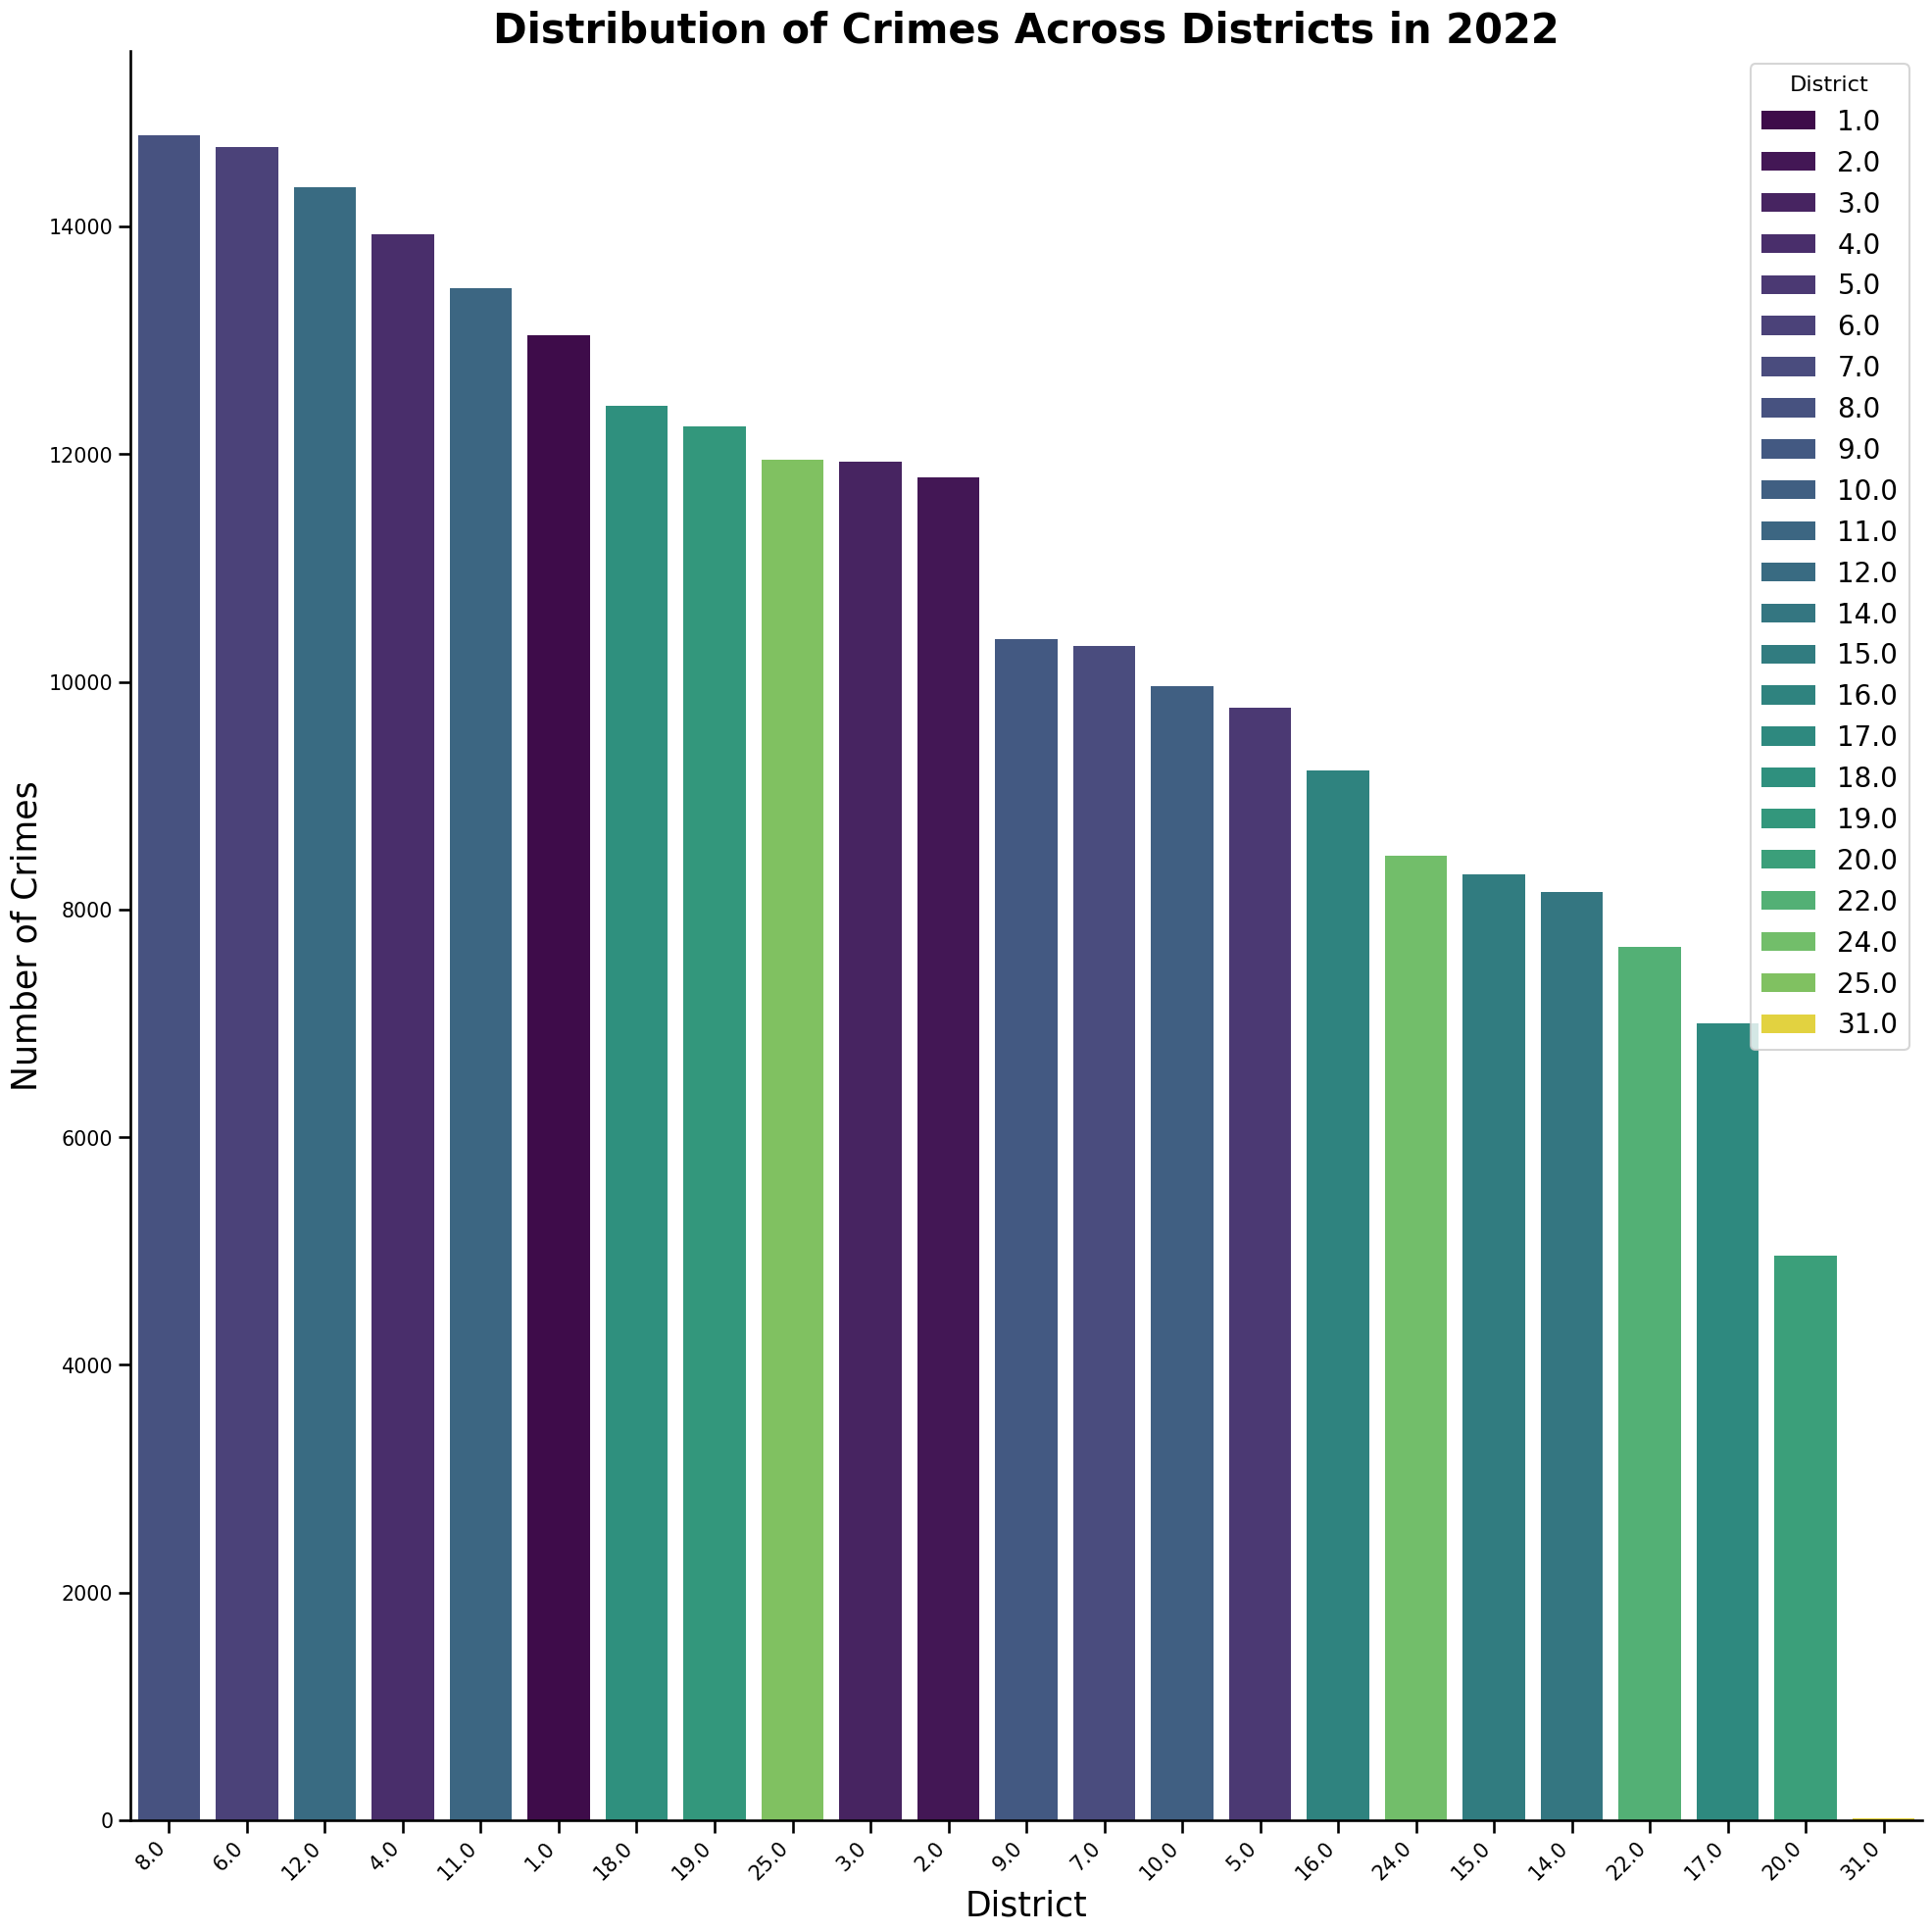

In [ ]:
# Calculate the order of districts based on crime count in descending order
order = Crimes_in_2022['District'].value_counts().index

# Creating a Countplot with seaborn (ordered by count)
plt.figure(figsize=(20, 20))
ax = sns.countplot(data=Crimes_in_2022, x="District", hue="District", legend="full", order=order, palette="viridis")

ax.set_title("Distribution of Crimes Across Districts in 2022", fontsize=30, fontweight='bold')
ax.set_xlabel("District", fontsize=25)
ax.set_ylabel("Number of Crimes", fontsize=25)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)
ax.legend(title="District", fontsize=20)

sns.despine()
plt.tight_layout()

plt.show()

# Crimes Across the Years

* Is the total number of crimes increasing or decreasing across the years?
* Are there any individual crimes that are doing the opposite (e.g., decreasing when overall crime is increasing or vice-versa)?

In [ ]:
df['year'].value_counts()

year
2002    486807
2001    485886
2003    475985
2004    469422
2005    453773
2006    448179
2007    437087
2008    427183
2009    392827
2010    370513
2011    351993
2012    336319
2013    307536
2014    275789
2016    269823
2017    269100
2018    268899
2015    264787
2019    261325
2022    238858
2020    212194
2021    208824
Name: count, dtype: int64

In [ ]:
# Saving the value_counts to use with seaborn
val_counts = df['District'].value_counts()
val_counts.head(10)

District
8.0     518549
11.0    495947
6.0     450645
7.0     447273
25.0    439160
4.0     437746
3.0     391059
12.0    381247
9.0     377311
2.0     364725
Name: count, dtype: int64

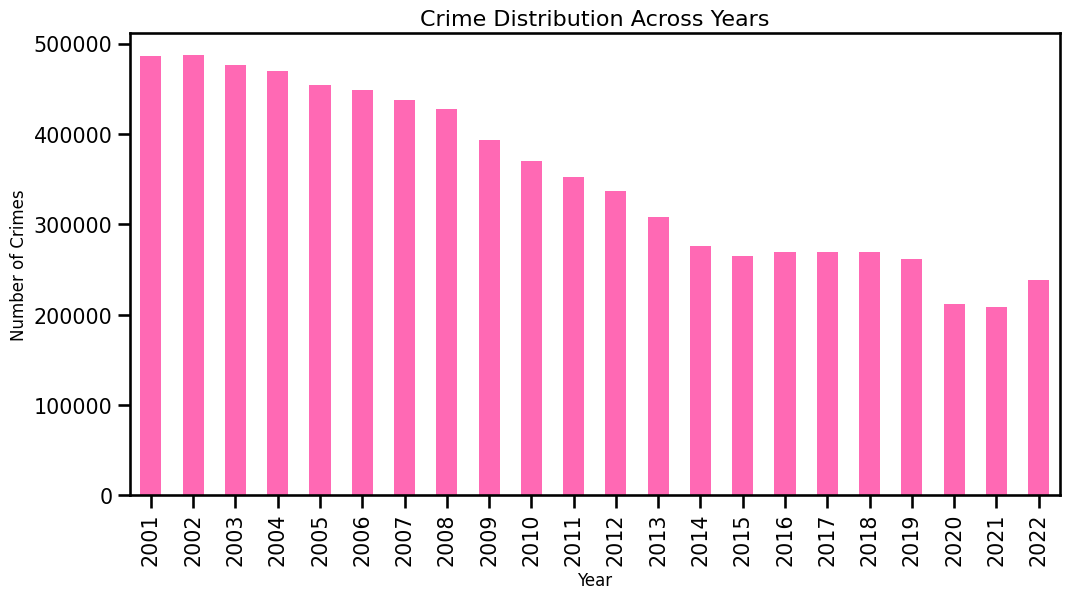

In [ ]:
df['year'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6), color='#FF69B4')
plt.title('Crime Distribution Across Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.show()

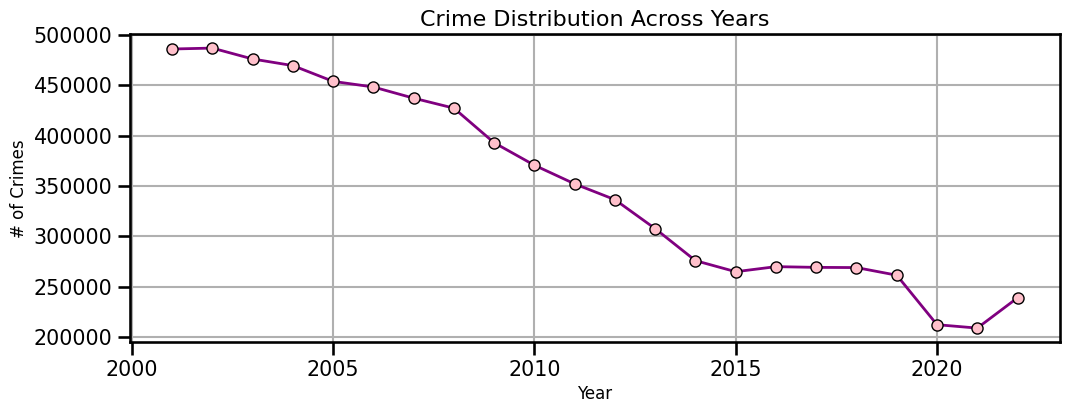

In [ ]:
year_counts = df['year'].value_counts().sort_index()
ax = year_counts.plot(style='o-', grid=True, marker='o', markersize=8, markerfacecolor='pink', markeredgecolor='black', linewidth=2, color='purple')
ax.set_ylabel('# of Crimes', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
plt.title('Crime Distribution Across Years', fontsize=16)
plt.show()

As we can see the number of crimes across the years is decreasing until 2021.
But in 2022 the number of crimes start increasing

In [ ]:
df.columns



Index(['Primary Type', 'Description', 'Location Description', 'Arrest',
       'Domestic', 'Beat', 'District', 'year'],
      dtype='object')

In [ ]:
Crimes_Type_by_year = df.groupby("Primary Type")["year"].value_counts().sort_index()
Crimes_Type_by_year

Primary Type       year
ARSON              2001    1011
                   2002    1032
                   2003     955
                   2004     778
                   2005     691
                           ... 
WEAPONS VIOLATION  2018    5456
                   2019    6339
                   2020    8432
                   2021    8980
                   2022    8766
Name: count, Length: 616, dtype: int64

<Axes: xlabel='Primary Type,year'>

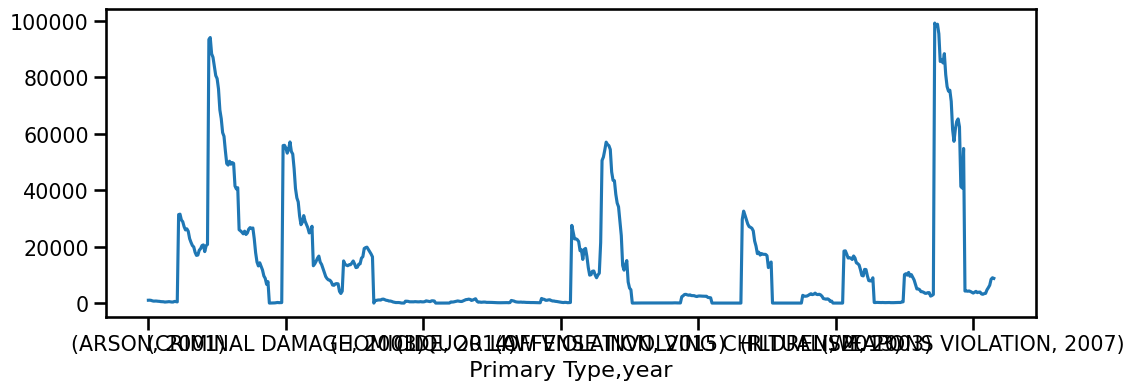

In [ ]:
Crimes_Type_by_year.plot()

In [ ]:
## convert to dataframe and reset_index()
plot_df = Crimes_Type_by_year.to_frame('# of Crimes').reset_index()
plot_df



Primary Type  year  # of Crimes
0                ARSON  2001         1011
1                ARSON  2002         1032
2                ARSON  2003          955
3                ARSON  2004          778
4                ARSON  2005          691
..                 ...   ...          ...
611  WEAPONS VIOLATION  2018         5456
612  WEAPONS VIOLATION  2019         6339
613  WEAPONS VIOLATION  2020         8432
614  WEAPONS VIOLATION  2021         8980
615  WEAPONS VIOLATION  2022         8766

[616 rows x 3 columns]

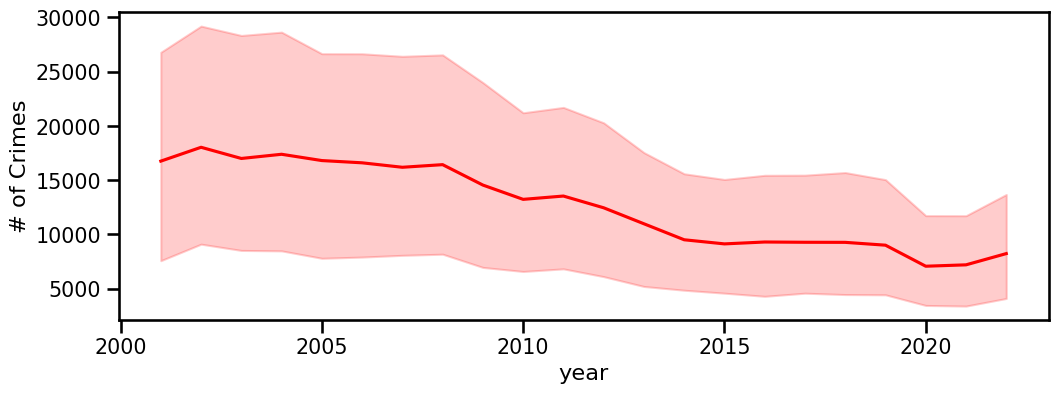

In [ ]:
ax = sns.lineplot(data=plot_df,x = 'year', y='# of Crimes', color = 'red')



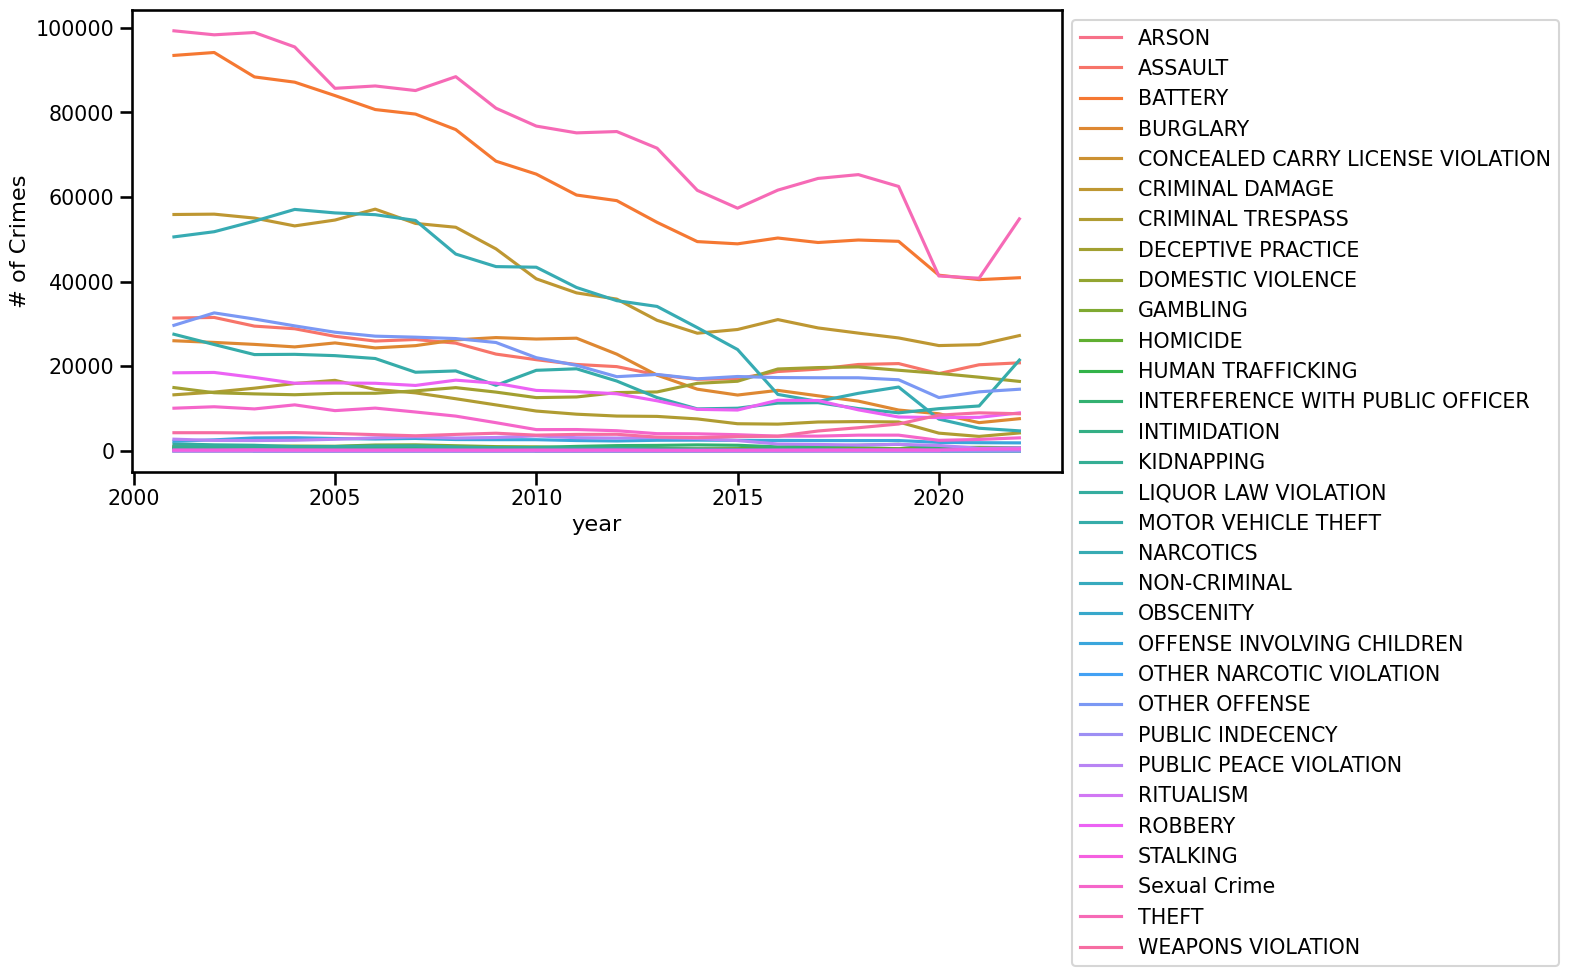

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=plot_df, x='year',y='# of Crimes',markers=True,
                  hue='Primary Type',ax=ax,)
ax.legend(bbox_to_anchor=[1,1]);


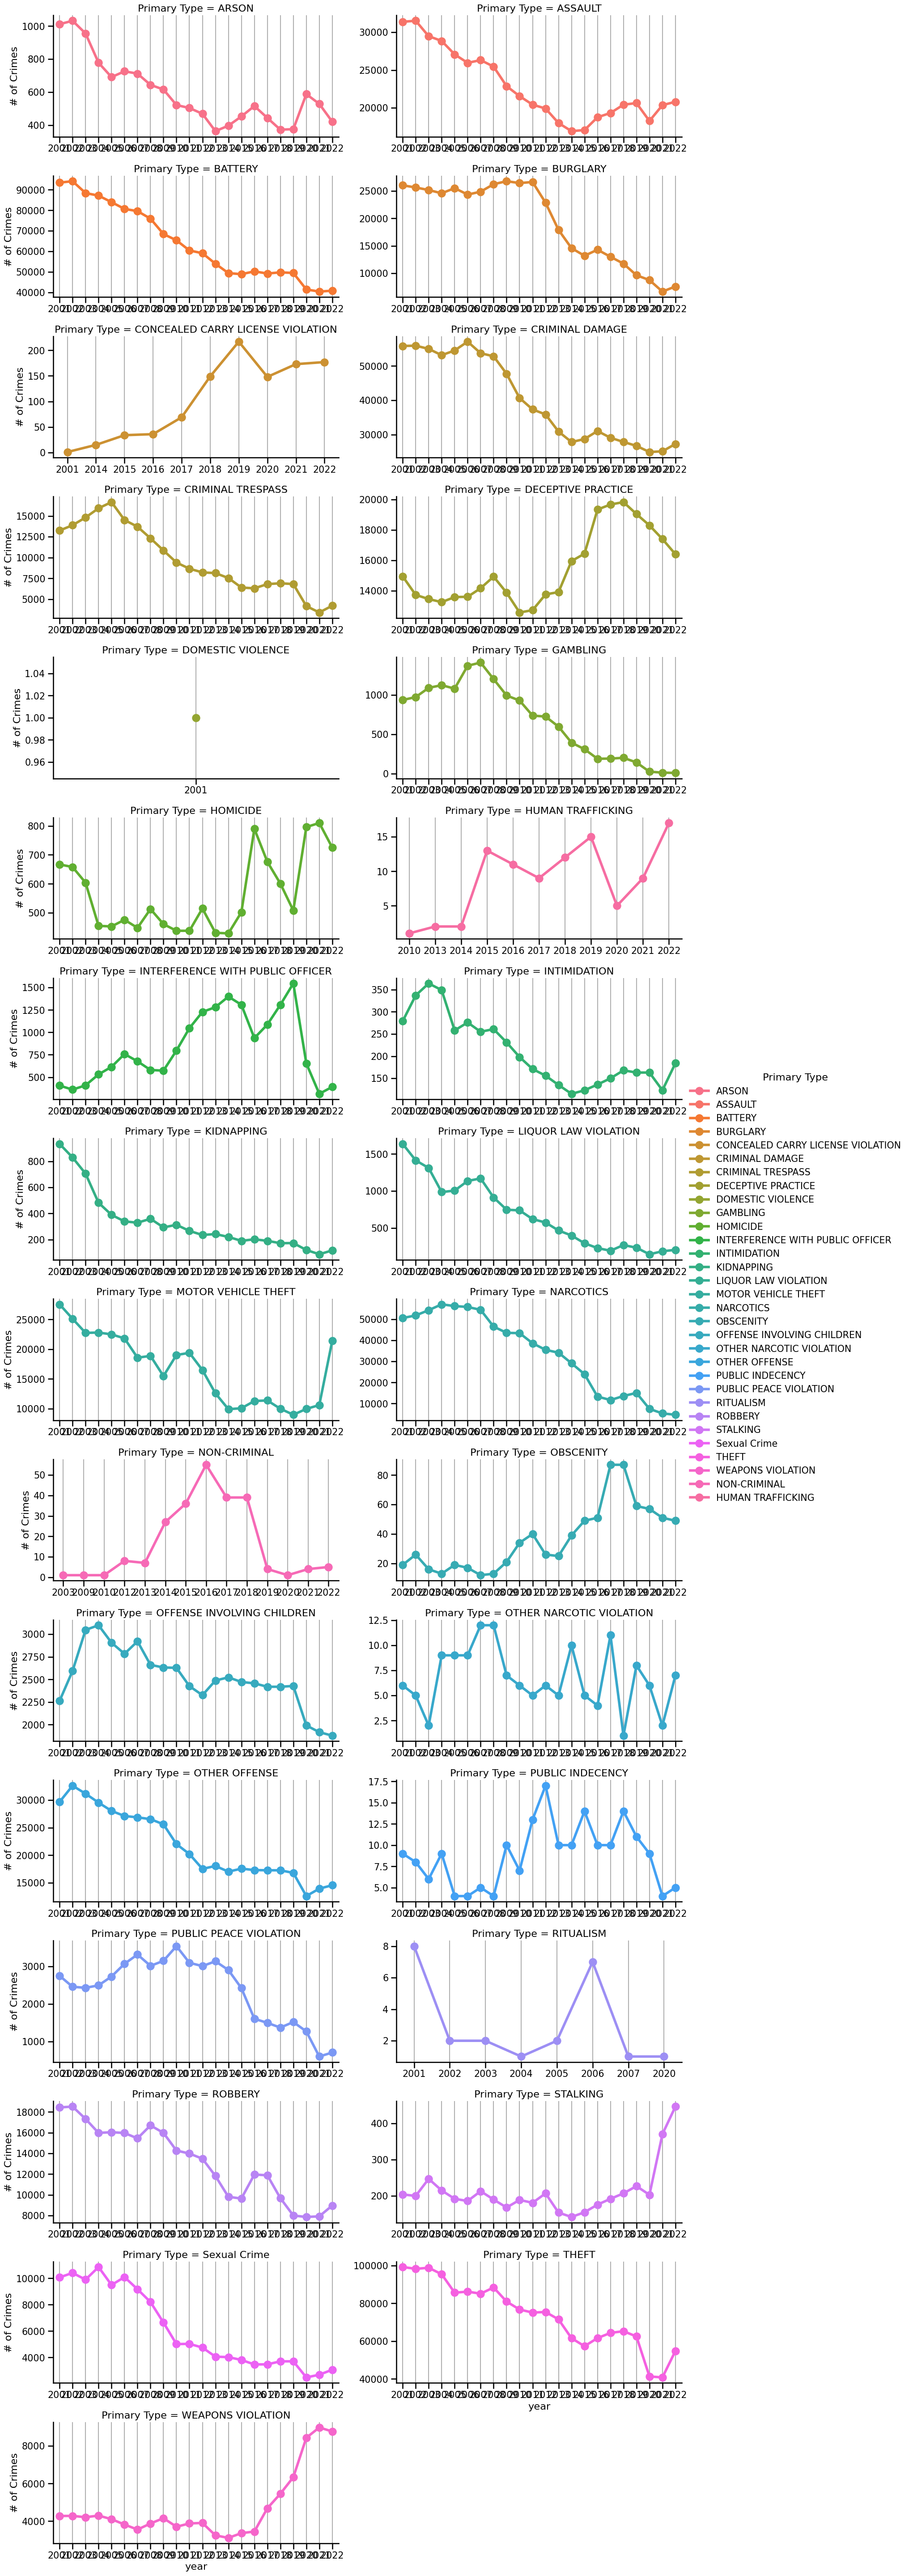

In [ ]:
g = sns.catplot(data=plot_df, x='year',y='# of Crimes', kind= 'point',
                  hue='Primary Type',aspect=2, height=4,
                  col='Primary Type',col_wrap=2,
                  sharey=False, sharex=False)
[ax.grid(axis='x') for ax in g.axes];



In [ ]:
Crimes_Type_perc_by_year = df.groupby("Primary Type")["year"].value_counts(normalize=True).sort_index()
Crimes_Type_perc_by_year

Primary Type       year
ARSON              2001    0.077052
                   2002    0.078653
                   2003    0.072784
                   2004    0.059294
                   2005    0.052664
                             ...   
WEAPONS VIOLATION  2018    0.052509
                   2019    0.061007
                   2020    0.081150
                   2021    0.086424
                   2022    0.084365
Name: proportion, Length: 616, dtype: float64

In [ ]:
## Convert to dataframe and reset index
plot_df_perc = Crimes_Type_perc_by_year.to_frame('# of Crimes').reset_index()
plot_df_perc

Primary Type  year  # of Crimes
0                ARSON  2001     0.077052
1                ARSON  2002     0.078653
2                ARSON  2003     0.072784
3                ARSON  2004     0.059294
4                ARSON  2005     0.052664
..                 ...   ...          ...
611  WEAPONS VIOLATION  2018     0.052509
612  WEAPONS VIOLATION  2019     0.061007
613  WEAPONS VIOLATION  2020     0.081150
614  WEAPONS VIOLATION  2021     0.086424
615  WEAPONS VIOLATION  2022     0.084365

[616 rows x 3 columns]

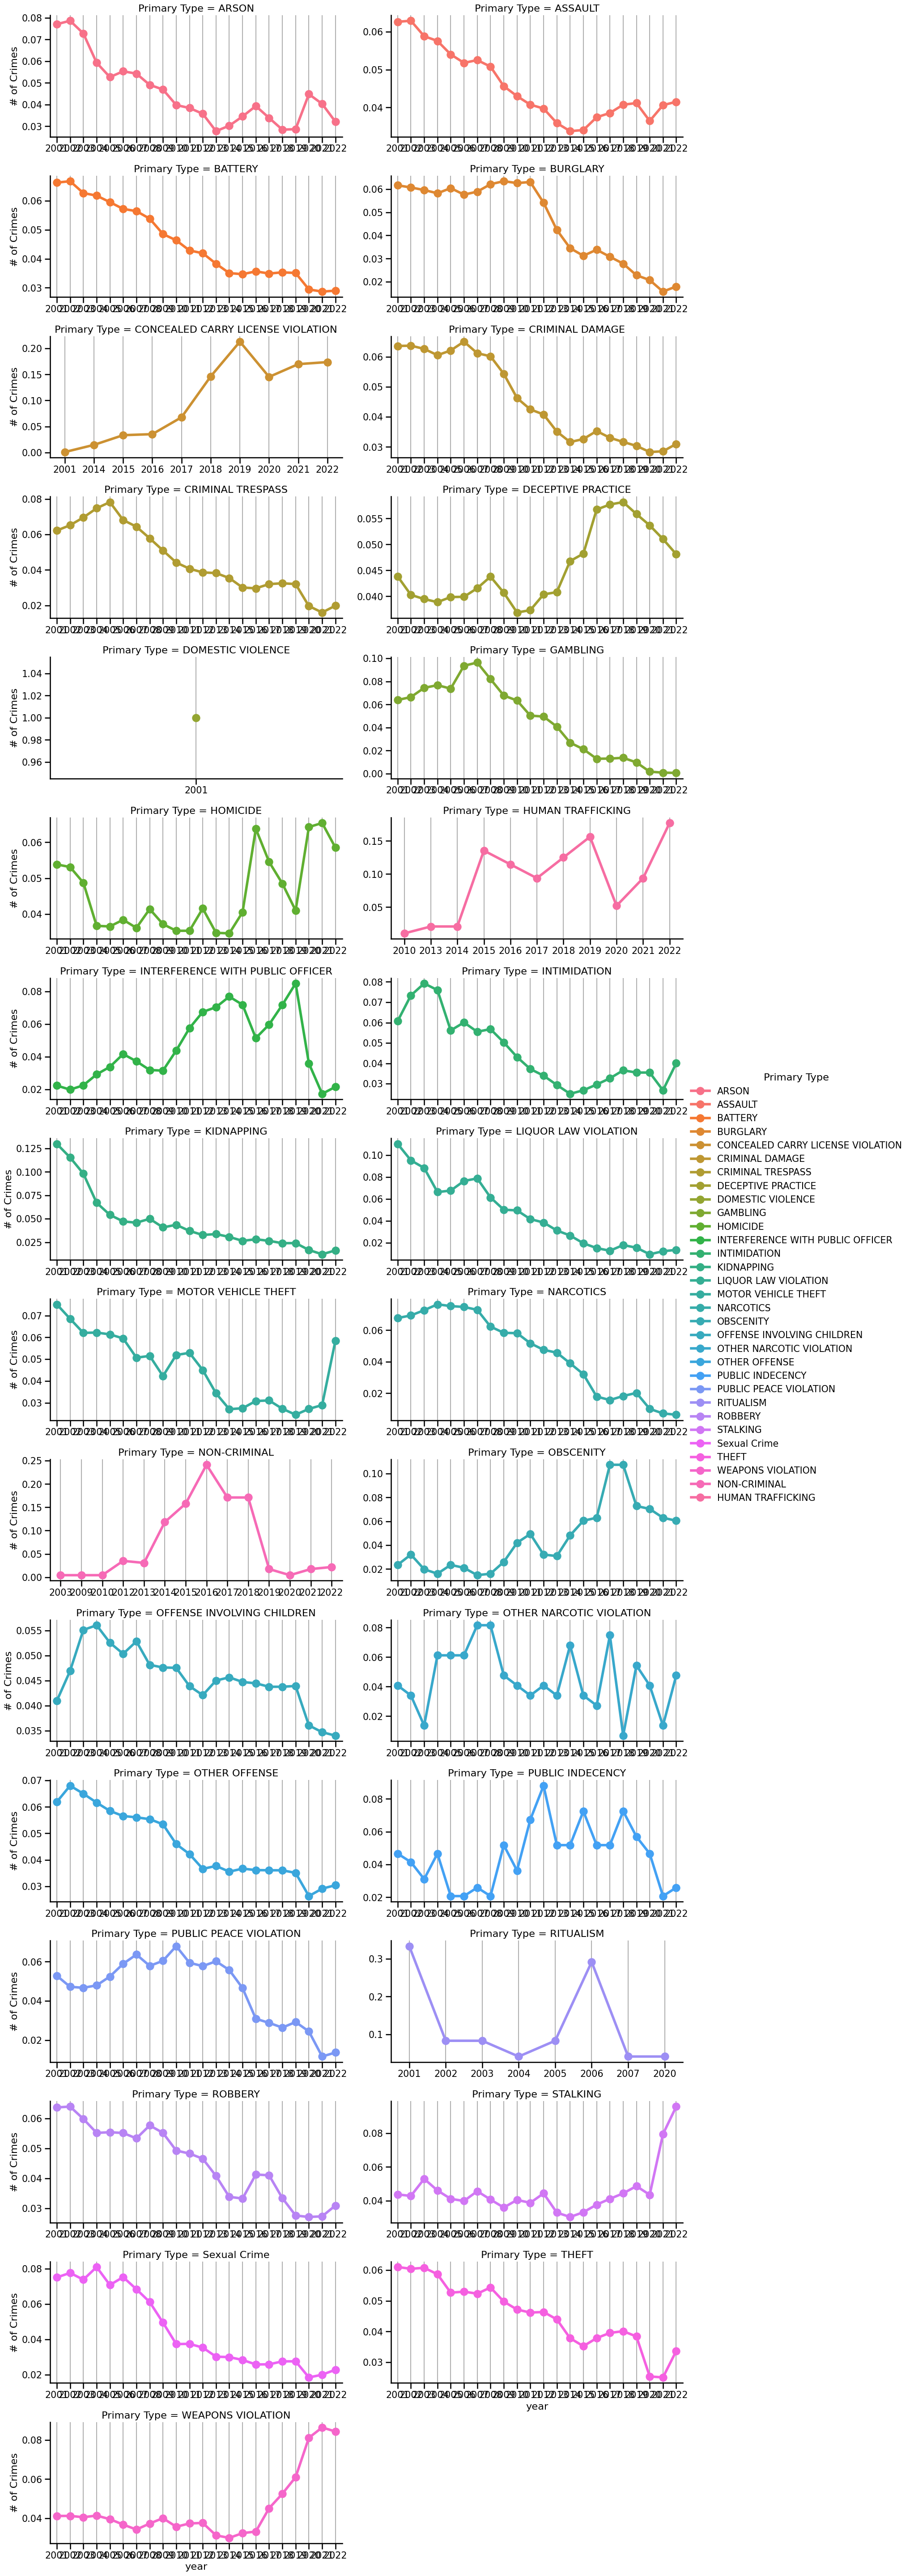

In [ ]:
g = sns.catplot(data=plot_df_perc, x='year',y='# of Crimes', kind= 'point',
                  hue='Primary Type',aspect=2, height=4,
                  col='Primary Type',col_wrap=2,
                  sharey=False, sharex=False)
[ax.grid(axis='x') for ax in g.axes];


Normalizing allows each of the crimes to have the same scale for easier comparisons.

**Looping through the groupby value counts**

In [ ]:
val_counts_by_year = df.groupby('Primary Type')['year'].value_counts()
val_counts_by_year

Primary Type       year
ARSON              2002    1032
                   2001    1011
                   2003     955
                   2004     778
                   2006     726
                           ... 
WEAPONS VIOLATION  2007    3554
                   2016    3450
                   2015    3364
                   2013    3245
                   2014    3113
Name: count, Length: 616, dtype: int64

In [ ]:
## Getting all of the crimes from the first level of the index
crime_list = val_counts_by_year.index.levels[0]
crime_list



Index(['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY',
       'CONCEALED CARRY LICENSE VIOLATION', 'CRIMINAL DAMAGE',
       'CRIMINAL TRESPASS', 'DECEPTIVE PRACTICE', 'DOMESTIC VIOLENCE',
       'GAMBLING', 'HOMICIDE', 'HUMAN TRAFFICKING',
       'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION', 'KIDNAPPING',
       'LIQUOR LAW VIOLATION', 'MOTOR VEHICLE THEFT', 'NARCOTICS',
       'NON-CRIMINAL', 'OBSCENITY', 'OFFENSE INVOLVING CHILDREN',
       'OTHER NARCOTIC VIOLATION', 'OTHER OFFENSE', 'PUBLIC INDECENCY',
       'PUBLIC PEACE VIOLATION', 'RITUALISM', 'ROBBERY', 'STALKING',
       'Sexual Crime', 'THEFT', 'WEAPONS VIOLATION'],
      dtype='object', name='Primary Type')

In [ ]:
##selecting a test crime and slicing the result
crime='HOMICIDE'
val_counts_by_year.loc[crime]



year
2021    810
2020    796
2016    790
2022    725
2017    676
2001    667
2002    658
2003    604
2018    601
2012    515
2008    513
2019    508
2015    502
2006    476
2009    461
2004    455
2005    453
2007    448
2010    438
2011    438
2013    431
2014    429
Name: count, dtype: int64

In [ ]:
## getting min and max values
val_counts_by_year.loc[crime].agg(['min','max'])



min    429
max    810
Name: count, dtype: int64

In [ ]:
##  Getting indices for min and max
val_counts_by_year.loc[crime].agg(['idxmin','idxmax'])



idxmin    2014
idxmax    2021
Name: count, dtype: int32

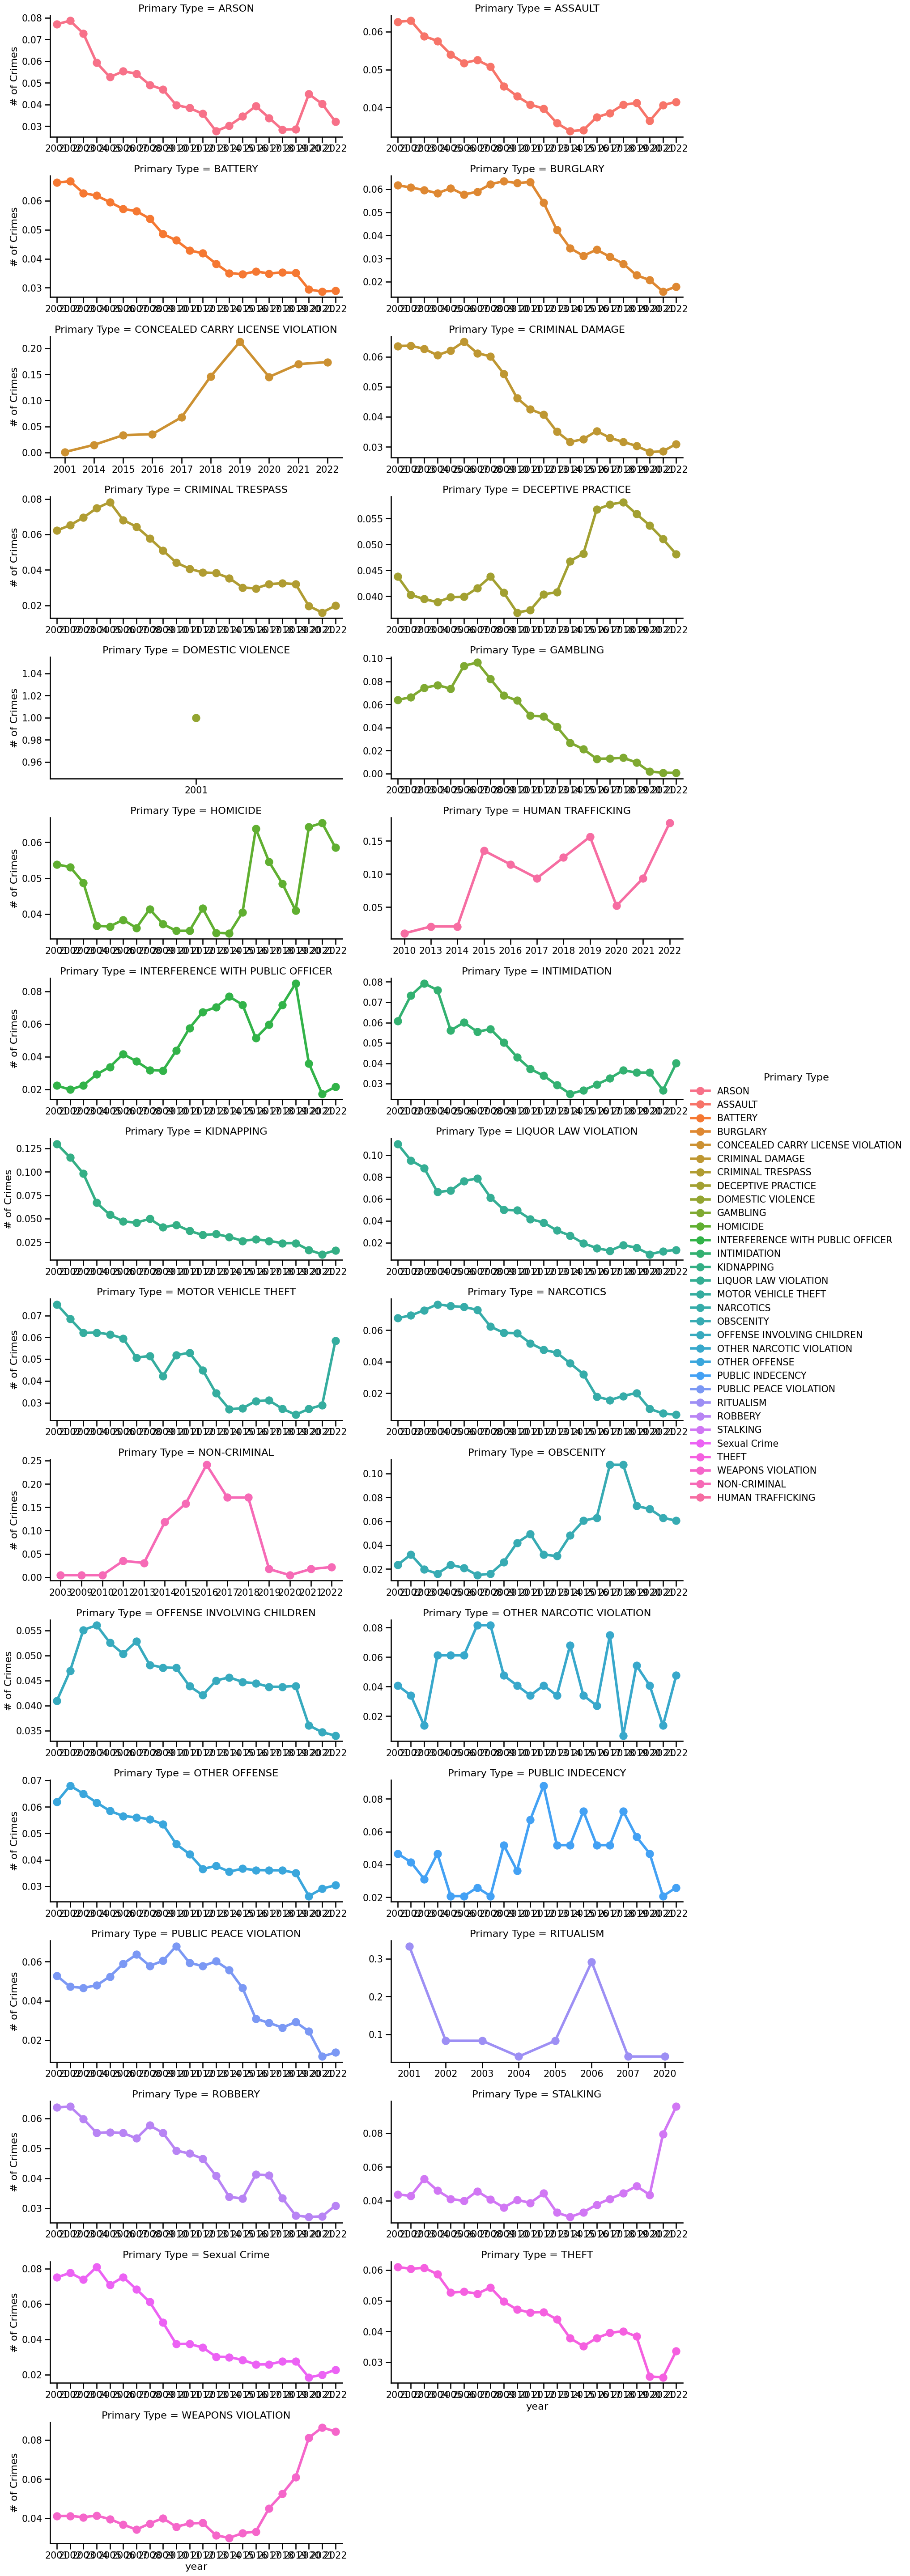

In [ ]:
g = sns.catplot(data=plot_df_perc, x='year', y='# of Crimes',
                hue='Primary Type', col='Primary Type',col_wrap=2,
            aspect=2, height=4,
           kind='point',sharey=False,sharex=False);

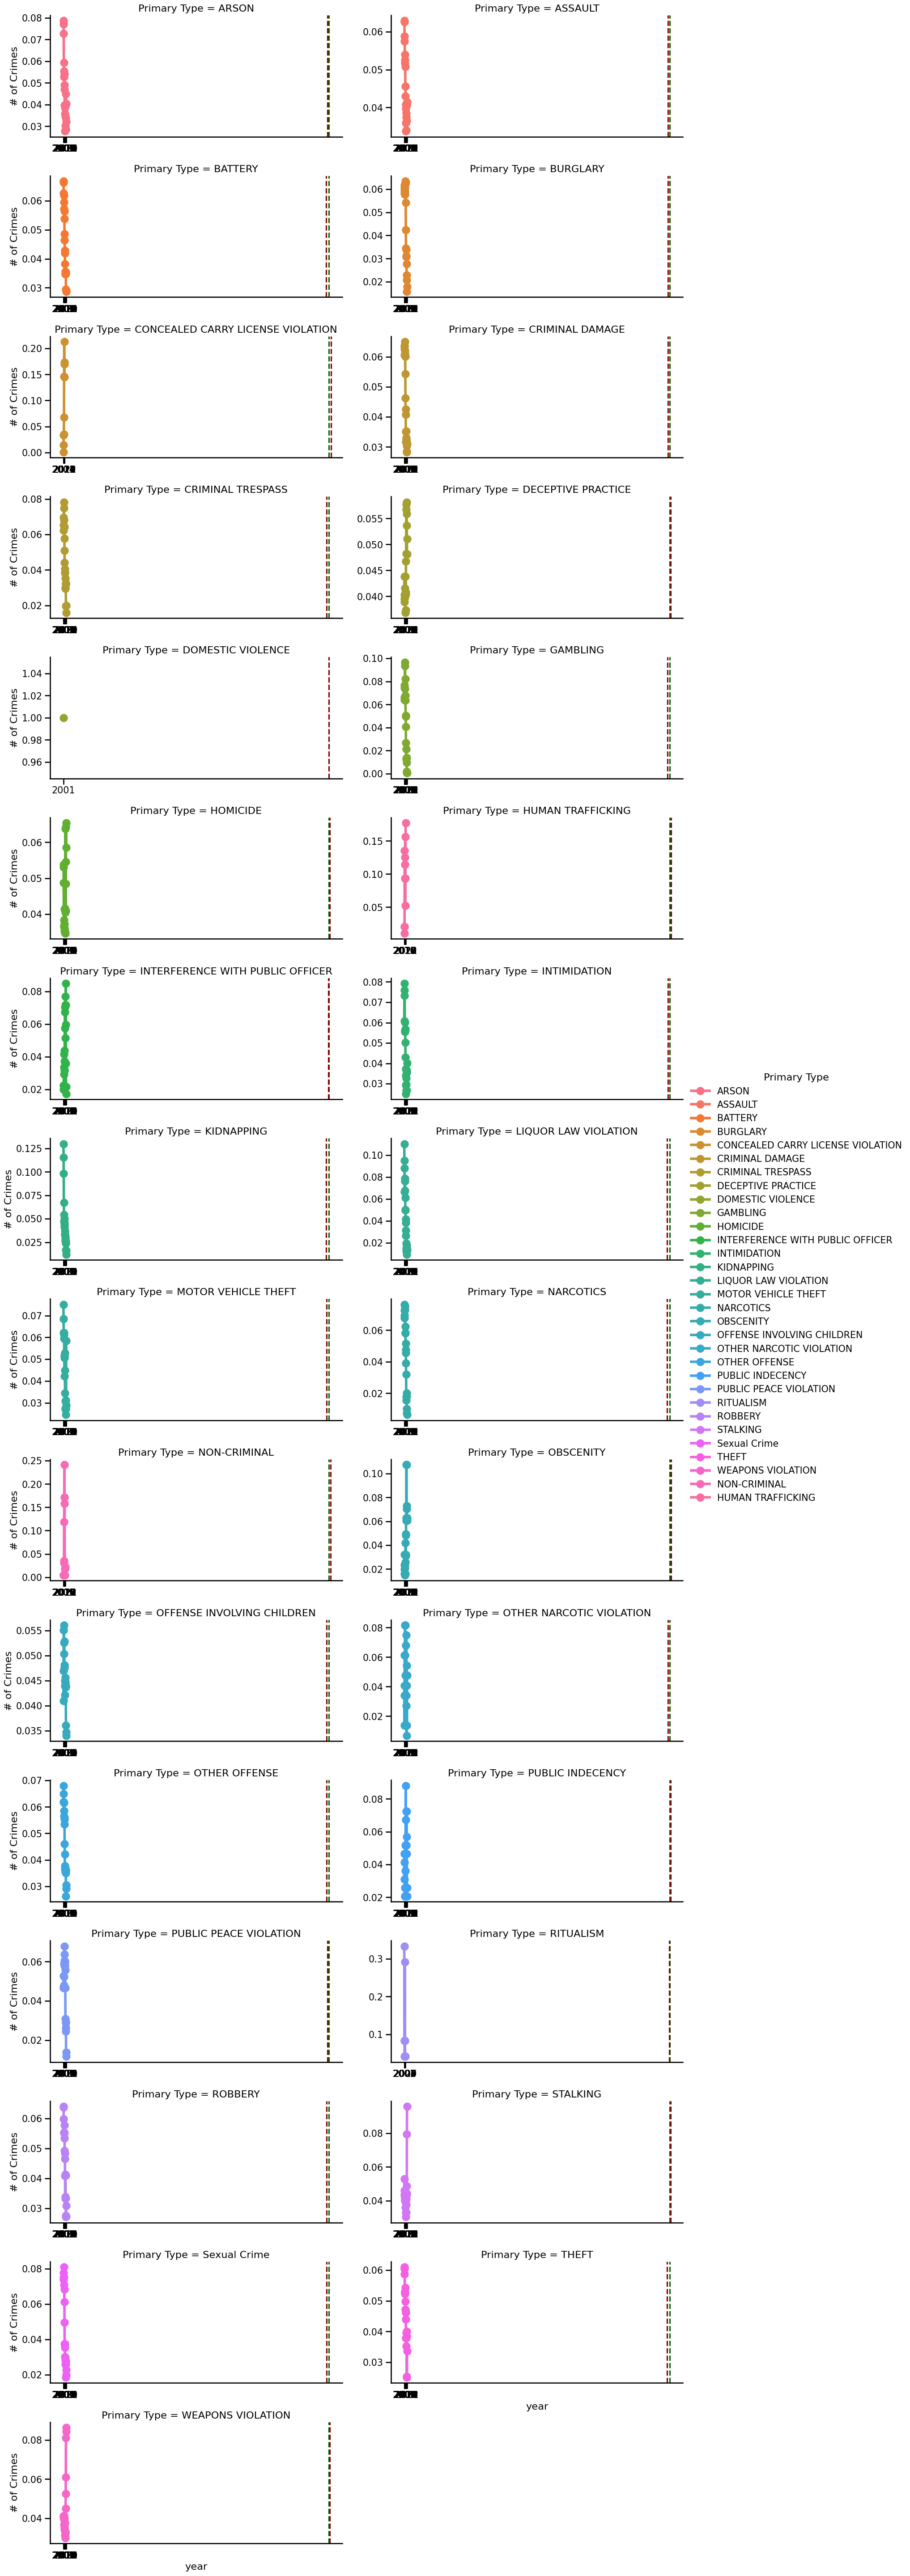

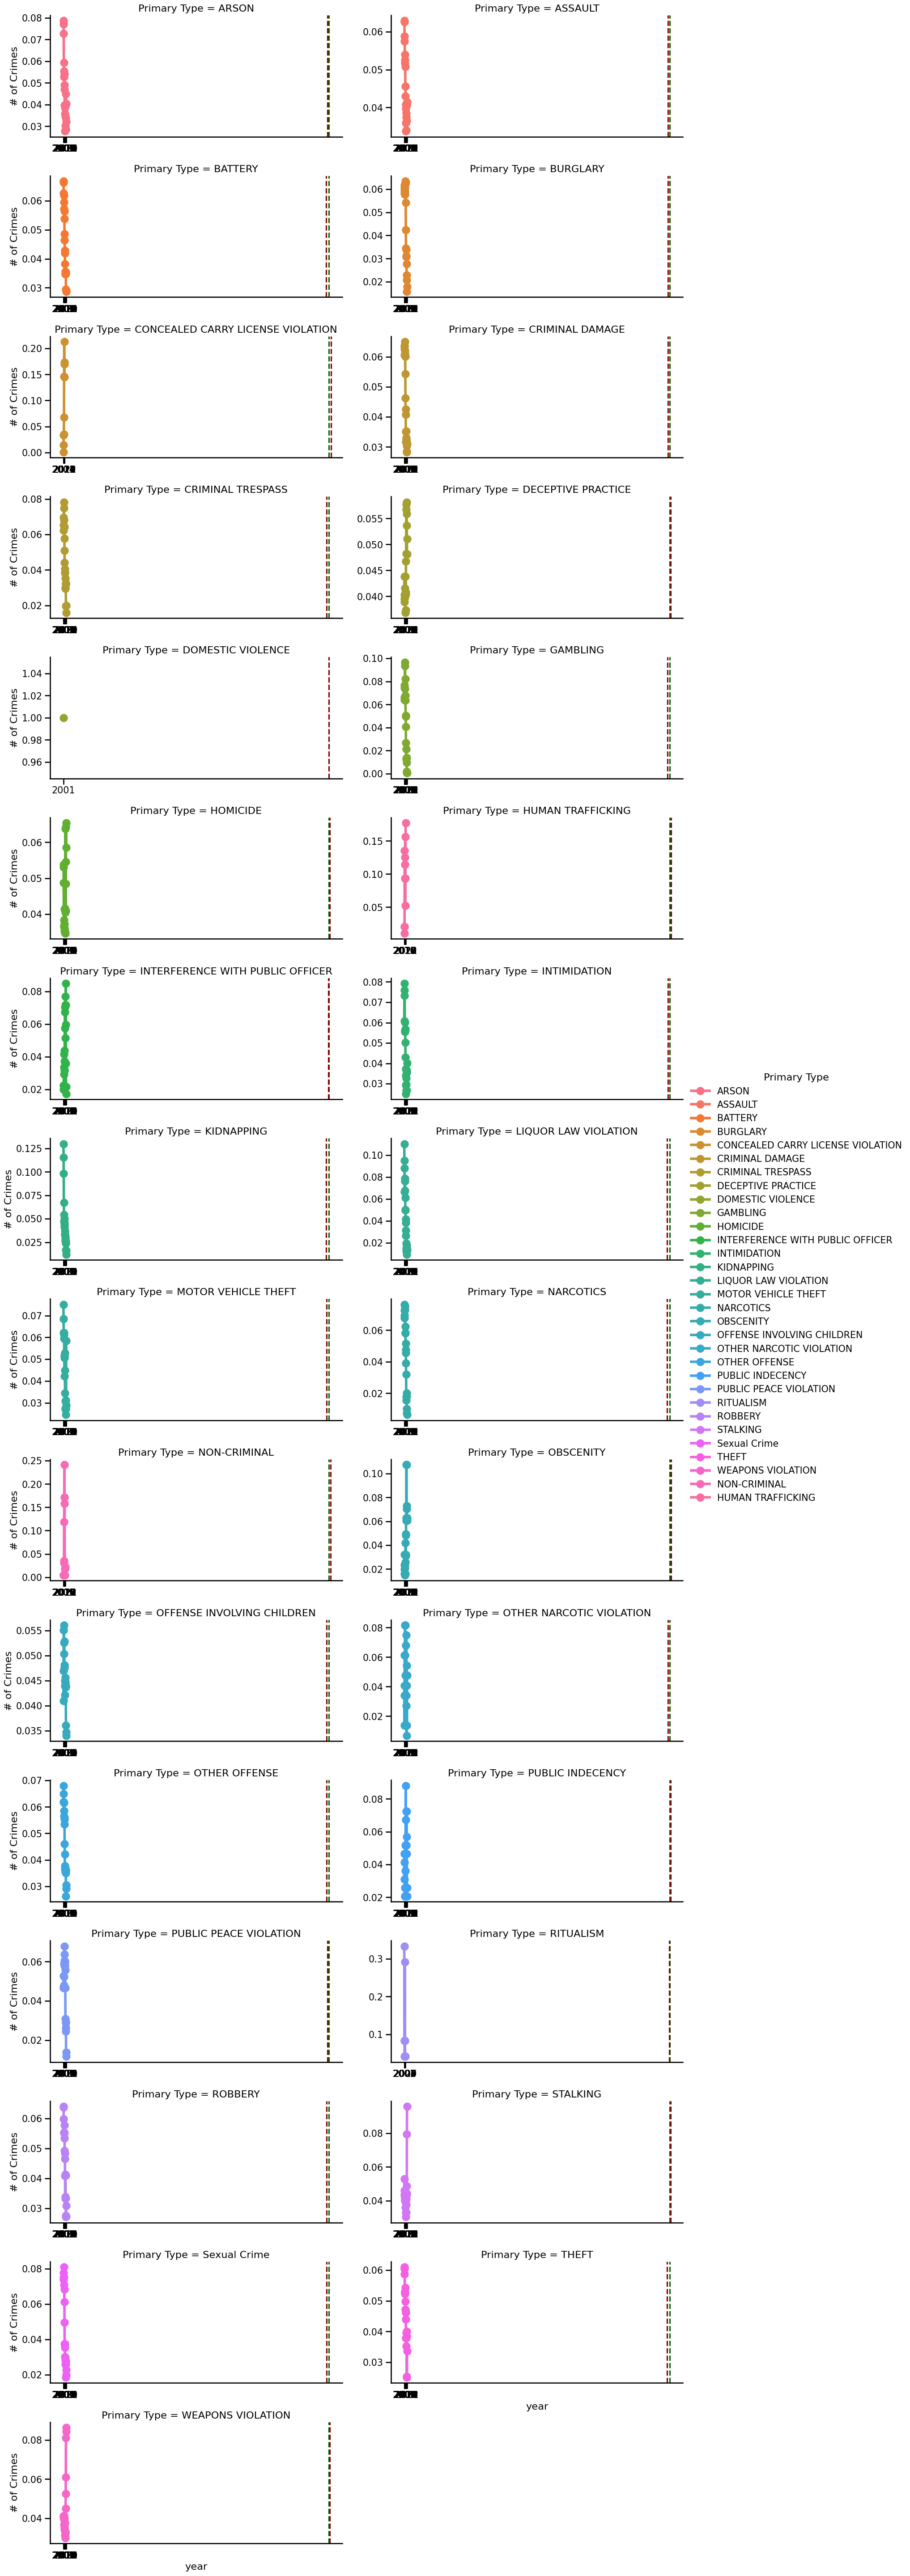

In [ ]:
g = sns.catplot(data=plot_df_perc, x='year', y='# of Crimes',
                hue='Primary Type', col='Primary Type',col_wrap=2,
            aspect=2, height=4,
           kind='point',sharey=False,sharex=False);
## loop throught the axes dict
for col, ax in g.axes_dict.items():

    ## Extract the idx min and idxmax from the val counts
    min_, max_ = val_counts_by_year.loc[col].agg(['idxmin','idxmax'])

    ## add vlines for both and SAVE THE LINE and a label to use in legend
    ln1 = ax.axvline(min_, color='darkgreen',ls='--')
    lab1 = f'Min(Hour={min_})'

    ln2 = ax.axvline(max_,color='darkred',ls='--')
    lab2 = f'Max(Hour={max_})'

g.fig



In [ ]:
df_Crimes_Groupby=plot_df_perc.groupby(["Primary Type", "year"])["# of Crimes"].sum().reset_index()

In [ ]:
df_Crimes_Groupby=pd.pivot_table(df_Crimes_Groupby,values="# of Crimes",index="year",columns="Primary Type").reset_index()

In [ ]:
df_Crimes_Groupby.head()

Primary Type  year     ARSON   ASSAULT   BATTERY  BURGLARY  \
0             2001  0.077052  0.062630  0.066243  0.061609   
1             2002  0.078653  0.062907  0.066733  0.060683   
2             2003  0.072784  0.058824  0.062641  0.059579   
3             2004  0.059294  0.057573  0.061760  0.058175   
4             2005  0.052664  0.054015  0.059511  0.060398   

Primary Type  CONCEALED CARRY LICENSE VIOLATION  CRIMINAL DAMAGE  \
0                                      0.000981         0.063555   
1                                           NaN         0.063648   
2                                           NaN         0.062590   
3                                           NaN         0.060488   
4                                           NaN         0.062063   

Primary Type  CRIMINAL TRESPASS  DECEPTIVE PRACTICE  DOMESTIC VIOLENCE  \
0                      0.062203            0.043844                1.0   
1                      0.065204            0.040275                NaN   
2                      0.069559            0.039474                NaN   
3                      0.074755            0.038876                NaN   
4                      0.078241            0.039858                NaN   

Primary Type  GAMBLING  HOMICIDE  HUMAN TRAFFICKING  \
0             0.063903  0.053816                NaN   
1             0.066434  0.053090                NaN   
2             0.074439  0.048733                NaN   
3             0.076765  0.036711                NaN   
4             0.073755  0.036550                NaN   

Primary Type  INTERFERENCE WITH PUBLIC OFFICER  INTIMIDATION  KIDNAPPING  \
0                                     0.022300      0.060718    0.129854   
1                                     0.019829      0.073341    0.115379   
2                                     0.022465      0.079217    0.098121   
3                                     0.029166      0.075952    0.067084   
4                                     0.033780      0.056148    0.054141   

Primary Type  LIQUOR LAW VIOLATION  MOTOR VEHICLE THEFT  NARCOTICS  \
0                         0.110265             0.075161   0.067770   
1                         0.095245             0.068527   0.069408   
2                         0.088307             0.062054   0.072757   
3                         0.066348             0.062209   0.076472   
4                         0.067695             0.061369   0.075365   

Primary Type  NON-CRIMINAL  OBSCENITY  OFFENSE INVOLVING CHILDREN  \
0                      NaN   0.023457                    0.040937   
1                      NaN   0.032099                    0.046925   
2                 0.004386   0.019753                    0.055119   
3                      NaN   0.016049                    0.056060   
4                      NaN   0.023457                    0.052569   

Primary Type  OTHER NARCOTIC VIOLATION  OTHER OFFENSE  PUBLIC INDECENCY  \
0                             0.040816       0.061902          0.046632   
1                             0.034014       0.068034          0.041451   
2                             0.013605       0.065004          0.031088   
3                             0.061224       0.061631          0.046632   
4                             0.061224       0.058492          0.020725   

Primary Type  PUBLIC PEACE VIOLATION  RITUALISM   ROBBERY  STALKING  \
0                           0.052797   0.333333  0.063661  0.043739   
1                           0.047172   0.083333  0.063944  0.042882   
2                           0.046654   0.083333  0.059832  0.052959   
3                           0.047902   0.041667  0.055158  0.046098   
4                           0.052413   0.083333  0.055396  0.041166   

Primary Type  Sexual Crime     THEFT  WEAPONS VIOLATION  
0                 0.075099  0.061019           0.041162  
1                 0.077649  0.060438           0.041201  
2                 0.073839  0.060772           0.040527  
3                 0.080974  0.058675   

In [ ]:
df_Crimes_Groupby=df_Crimes_Groupby.set_index("year")

In [ ]:
df_Crimes_Groupby.head()

Primary Type     ARSON   ASSAULT   BATTERY  BURGLARY  \
year                                                   
2001          0.077052  0.062630  0.066243  0.061609   
2002          0.078653  0.062907  0.066733  0.060683   
2003          0.072784  0.058824  0.062641  0.059579   
2004          0.059294  0.057573  0.061760  0.058175   
2005          0.052664  0.054015  0.059511  0.060398   

Primary Type  CONCEALED CARRY LICENSE VIOLATION  CRIMINAL DAMAGE  \
year                                                               
2001                                   0.000981         0.063555   
2002                                        NaN         0.063648   
2003                                        NaN         0.062590   
2004                                        NaN         0.060488   
2005                                        NaN         0.062063   

Primary Type  CRIMINAL TRESPASS  DECEPTIVE PRACTICE  DOMESTIC VIOLENCE  \
year                                                                     
2001                   0.062203            0.043844                1.0   
2002                   0.065204            0.040275                NaN   
2003                   0.069559            0.039474                NaN   
2004                   0.074755            0.038876                NaN   
2005                   0.078241            0.039858                NaN   

Primary Type  GAMBLING  HOMICIDE  HUMAN TRAFFICKING  \
year                                                  
2001          0.063903  0.053816                NaN   
2002          0.066434  0.053090                NaN   
2003          0.074439  0.048733                NaN   
2004          0.076765  0.036711                NaN   
2005          0.073755  0.036550                NaN   

Primary Type  INTERFERENCE WITH PUBLIC OFFICER  INTIMIDATION  KIDNAPPING  \
year                                                                       
2001                                  0.022300      0.060718    0.129854   
2002                                  0.019829      0.073341    0.115379   
2003                                  0.022465      0.079217    0.098121   
2004                                  0.029166      0.075952    0.067084   
2005                                  0.033780      0.056148    0.054141   

Primary Type  LIQUOR LAW VIOLATION  MOTOR VEHICLE THEFT  NARCOTICS  \
year                                                                 
2001                      0.110265             0.075161   0.067770   
2002                      0.095245             0.068527   0.069408   
2003                      0.088307             0.062054   0.072757   
2004                      0.066348             0.062209   0.076472   
2005                      0.067695             0.061369   0.075365   

Primary Type  NON-CRIMINAL  OBSCENITY  OFFENSE INVOLVING CHILDREN  \
year                                                                
2001                   NaN   0.023457                    0.040937   
2002                   NaN   0.032099                    0.046925   
2003              0.004386   0.019753                    0.055119   
2004                   NaN   0.016049                    0.056060   
2005                   NaN   0.023457                    0.052569   

Primary Type  OTHER NARCOTIC VIOLATION  OTHER OFFENSE  PUBLIC INDECENCY  \
year                                                                      
2001                          0.040816       0.061902          0.046632   
2002                          0.034014       0.068034          0.041451   
2003                          0.013605       0.065004          0.031088   
2004                          0.061224       0.061631          0.046632   
2005                          0.061224       0.058492          0.020725   

Primary Type  PUBLIC PEACE VIOLATION  RITUALISM   ROBBERY  STALKING  \
year                                                                  
2001                        0.052797   0.333333  

In [ ]:
df_Crimes_Groupby.tail()

Primary Type     ARSON   ASSAULT   BATTERY  BURGLARY  \
year                                                   
2018          0.028428  0.040722  0.035317  0.027820   
2019          0.028656  0.041149  0.035096  0.022826   
2020          0.044814  0.036424  0.029423  0.020739   
2021          0.040317  0.040594  0.028678  0.015770   
2022          0.032086  0.041500  0.028997  0.017980   

Primary Type  CONCEALED CARRY LICENSE VIOLATION  CRIMINAL DAMAGE  \
year                                                               
2018                                   0.146222         0.031656   
2019                                   0.212954         0.030357   
2020                                   0.145240         0.028304   
2021                                   0.169774         0.028551   
2022                                   0.173700         0.030994   

Primary Type  CRIMINAL TRESPASS  DECEPTIVE PRACTICE  DOMESTIC VIOLENCE  \
year                                                                     
2018                   0.032457            0.058168                NaN   
2019                   0.032034            0.055863                NaN   
2020                   0.019622            0.053681                NaN   
2021                   0.016000            0.051044                NaN   
2022                   0.019848            0.048114                NaN   

Primary Type  GAMBLING  HOMICIDE  HUMAN TRAFFICKING  \
year                                                  
2018          0.013752  0.048491           0.125000   
2019          0.009715  0.040988           0.156250   
2020          0.001710  0.064225           0.052083   
2021          0.000889  0.065354           0.093750   
2022          0.000616  0.058496           0.177083   

Primary Type  INTERFERENCE WITH PUBLIC OFFICER  INTIMIDATION  KIDNAPPING  \
year                                                                       
2018                                  0.071790      0.036561    0.023939   
2019                                  0.084917      0.035473    0.024078   
2020                                  0.035922      0.035473    0.016701   
2021                                  0.017247      0.026768    0.012109   
2022                                  0.021531      0.040044    0.016284   

Primary Type  LIQUOR LAW VIOLATION  MOTOR VEHICLE THEFT  NARCOTICS  \
year                                                                 
2018                      0.018052             0.027238   0.018213   
2019                      0.015627             0.024488   0.020200   
2020                      0.009632             0.027167   0.010041   
2021                      0.012394             0.028921   0.007153   
2022                      0.013674             0.058510   0.006322   

Primary Type  NON-CRIMINAL  OBSCENITY  OFFENSE INVOLVING CHILDREN  \
year                                                                
2018              0.171053   0.107407                    0.043759   
2019              0.017544   0.072840                    0.043922   
2020              0.004386   0.070370                    0.036035   
2021              0.017544   0.062963                    0.034678   
2022              0.021930   0.060494                    0.033991   

Primary Type  OTHER NARCOTIC VIOLATION  OTHER OFFENSE  PUBLIC INDECENCY  \
year                                                                      
2018                          0.006803       0.036029          0.072539   
2019                          0.054422       0.035052          0.056995   
2020                          0.040816       0.026281          0.046632   
2021                          0.013605       0.029098          0.020725   
2022                          0.047619       0.030381          0.025907   

Primary Type  PUBLIC PEACE VIOLATION  RITUALISM   ROBBERY  STALKING  \
year                                                                  
2018                        0.026341        NaN  

In [ ]:
df_Crimes_Groupby.fillna(0,inplace=True)

In [ ]:
df_Crimes_Groupby.tail()

Primary Type     ARSON   ASSAULT   BATTERY  BURGLARY  \
year                                                   
2018          0.028428  0.040722  0.035317  0.027820   
2019          0.028656  0.041149  0.035096  0.022826   
2020          0.044814  0.036424  0.029423  0.020739   
2021          0.040317  0.040594  0.028678  0.015770   
2022          0.032086  0.041500  0.028997  0.017980   

Primary Type  CONCEALED CARRY LICENSE VIOLATION  CRIMINAL DAMAGE  \
year                                                               
2018                                   0.146222         0.031656   
2019                                   0.212954         0.030357   
2020                                   0.145240         0.028304   
2021                                   0.169774         0.028551   
2022                                   0.173700         0.030994   

Primary Type  CRIMINAL TRESPASS  DECEPTIVE PRACTICE  DOMESTIC VIOLENCE  \
year                                                                     
2018                   0.032457            0.058168                0.0   
2019                   0.032034            0.055863                0.0   
2020                   0.019622            0.053681                0.0   
2021                   0.016000            0.051044                0.0   
2022                   0.019848            0.048114                0.0   

Primary Type  GAMBLING  HOMICIDE  HUMAN TRAFFICKING  \
year                                                  
2018          0.013752  0.048491           0.125000   
2019          0.009715  0.040988           0.156250   
2020          0.001710  0.064225           0.052083   
2021          0.000889  0.065354           0.093750   
2022          0.000616  0.058496           0.177083   

Primary Type  INTERFERENCE WITH PUBLIC OFFICER  INTIMIDATION  KIDNAPPING  \
year                                                                       
2018                                  0.071790      0.036561    0.023939   
2019                                  0.084917      0.035473    0.024078   
2020                                  0.035922      0.035473    0.016701   
2021                                  0.017247      0.026768    0.012109   
2022                                  0.021531      0.040044    0.016284   

Primary Type  LIQUOR LAW VIOLATION  MOTOR VEHICLE THEFT  NARCOTICS  \
year                                                                 
2018                      0.018052             0.027238   0.018213   
2019                      0.015627             0.024488   0.020200   
2020                      0.009632             0.027167   0.010041   
2021                      0.012394             0.028921   0.007153   
2022                      0.013674             0.058510   0.006322   

Primary Type  NON-CRIMINAL  OBSCENITY  OFFENSE INVOLVING CHILDREN  \
year                                                                
2018              0.171053   0.107407                    0.043759   
2019              0.017544   0.072840                    0.043922   
2020              0.004386   0.070370                    0.036035   
2021              0.017544   0.062963                    0.034678   
2022              0.021930   0.060494                    0.033991   

Primary Type  OTHER NARCOTIC VIOLATION  OTHER OFFENSE  PUBLIC INDECENCY  \
year                                                                      
2018                          0.006803       0.036029          0.072539   
2019                          0.054422       0.035052          0.056995   
2020                          0.040816       0.026281          0.046632   
2021                          0.013605       0.029098          0.020725   
2022                          0.047619       0.030381          0.025907   

Primary Type  PUBLIC PEACE VIOLATION  RITUALISM   ROBBERY  STALKING  \
year                                                                  
2018                        0.026341   0.000000  

We can use ts.diff(), which will subtract the previous row from the next row.

In [ ]:
df_diff = df_Crimes_Groupby.diff()
df_diff.head()



Primary Type     ARSON   ASSAULT   BATTERY  BURGLARY  \
year                                                   
2001               NaN       NaN       NaN       NaN   
2002          0.001600  0.000277  0.000490 -0.000926   
2003         -0.005868 -0.004083 -0.004092 -0.001104   
2004         -0.013490 -0.001251 -0.000882 -0.001404   
2005         -0.006631 -0.003558 -0.002248  0.002224   

Primary Type  CONCEALED CARRY LICENSE VIOLATION  CRIMINAL DAMAGE  \
year                                                               
2001                                        NaN              NaN   
2002                                  -0.000981         0.000093   
2003                                   0.000000        -0.001058   
2004                                   0.000000        -0.002101   
2005                                   0.000000         0.001575   

Primary Type  CRIMINAL TRESPASS  DECEPTIVE PRACTICE  DOMESTIC VIOLENCE  \
year                                                                     
2001                        NaN                 NaN                NaN   
2002                   0.003002           -0.003569               -1.0   
2003                   0.004355           -0.000801                0.0   
2004                   0.005196           -0.000598                0.0   
2005                   0.003486            0.000983                0.0   

Primary Type  GAMBLING  HOMICIDE  HUMAN TRAFFICKING  \
year                                                  
2001               NaN       NaN                NaN   
2002          0.002531 -0.000726                0.0   
2003          0.008005 -0.004357                0.0   
2004          0.002326 -0.012022                0.0   
2005         -0.003010 -0.000161                0.0   

Primary Type  INTERFERENCE WITH PUBLIC OFFICER  INTIMIDATION  KIDNAPPING  \
year                                                                       
2001                                       NaN           NaN         NaN   
2002                                 -0.002472      0.012622   -0.014475   
2003                                  0.002636      0.005876   -0.017258   
2004                                  0.006701     -0.003264   -0.031037   
2005                                  0.004614     -0.019804   -0.012944   

Primary Type  LIQUOR LAW VIOLATION  MOTOR VEHICLE THEFT  NARCOTICS  \
year                                                                 
2001                           NaN                  NaN        NaN   
2002                     -0.015021            -0.006634   0.001638   
2003                     -0.006938            -0.006473   0.003349   
2004                     -0.021959             0.000155   0.003715   
2005                      0.001347            -0.000840  -0.001107   

Primary Type  NON-CRIMINAL  OBSCENITY  OFFENSE INVOLVING CHILDREN  \
year                                                                
2001                   NaN        NaN                         NaN   
2002              0.000000   0.008642                    0.005988   
2003              0.004386  -0.012346                    0.008195   
2004             -0.004386  -0.003704                    0.000941   
2005              0.000000   0.007407                   -0.003491   

Primary Type  OTHER NARCOTIC VIOLATION  OTHER OFFENSE  PUBLIC INDECENCY  \
year                                                                      
2001                               NaN            NaN               NaN   
2002                         -0.006803       0.006131         -0.005181   
2003                         -0.020408      -0.003030         -0.010363   
2004                          0.047619      -0.003372          0.015544   
2005                          0.000000      -0.003139         -0.025907   

Primary Type  PUBLIC PEACE VIOLATION  RITUALISM   ROBBERY  STALKING  \
year                                                                  
2001                             NaN        NaN  

In [ ]:
changing_in_crime = df_diff.sum()
changing_in_crime


Primary Type
ARSON                               -0.044966
ASSAULT                             -0.021129
BATTERY                             -0.037246
BURGLARY                            -0.043629
CONCEALED CARRY LICENSE VIOLATION    0.172718
CRIMINAL DAMAGE                     -0.032561
CRIMINAL TRESPASS                   -0.042355
DECEPTIVE PRACTICE                   0.004270
DOMESTIC VIOLENCE                   -1.000000
GAMBLING                            -0.063287
HOMICIDE                             0.004680
HUMAN TRAFFICKING                    0.177083
INTERFERENCE WITH PUBLIC OFFICER    -0.000769
INTIMIDATION                        -0.020675
KIDNAPPING                          -0.113570
LIQUOR LAW VIOLATION                -0.096592
MOTOR VEHICLE THEFT                 -0.016651
NARCOTICS                           -0.061448
NON-CRIMINAL                         0.021930
OBSCENITY                            0.037037
OFFENSE INVOLVING CHILDREN          -0.006946
OTHER NARCOTIC VIOLATION             0.006803
OTHER OFFENSE                       -0.031521
PUBLIC INDECENCY                    -0.020725
PUBLIC PEACE VIOLATION              -0.039166
RITUALISM                           -0.333333
ROBBERY                             -0.032712
STALKING                             0.051887
Sexual Crime                        -0.052233
THEFT                               -0.027325
WEAPONS VIOLATION                    0.043203
dtype: float64

''

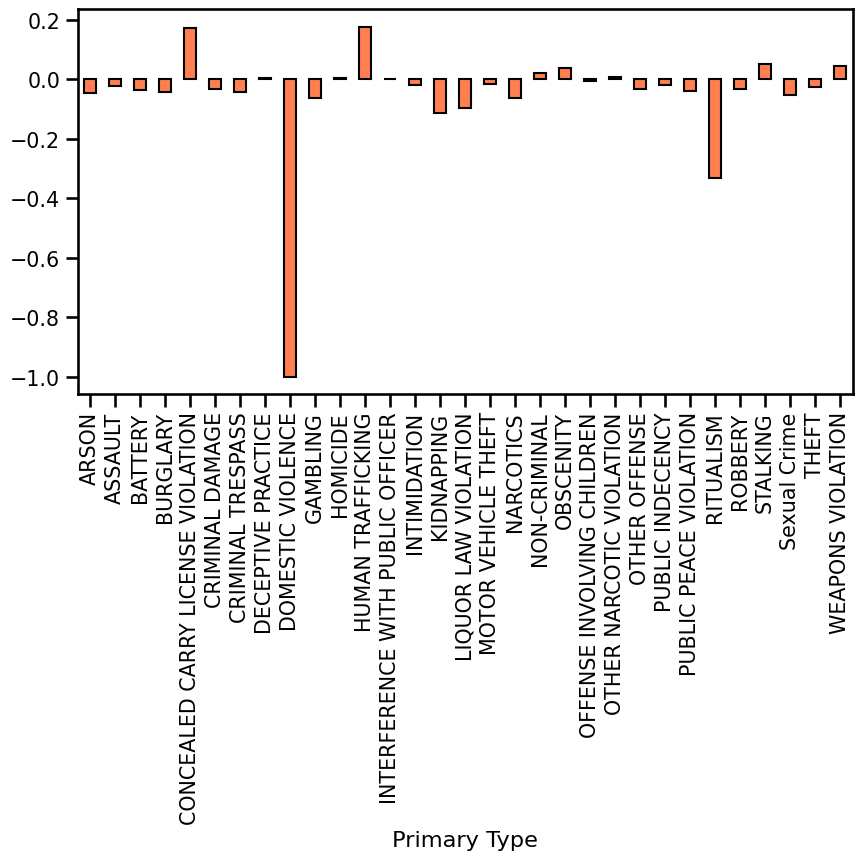

In [ ]:
changing_in_crime.plot(kind='bar',figsize=(10,5), color='coral', edgecolor='black')
;

In [ ]:
increased_crime_types = changing_in_crime[changing_in_crime > 0]
increased_crime_types

Primary Type
CONCEALED CARRY LICENSE VIOLATION    0.172718
DECEPTIVE PRACTICE                   0.004270
HOMICIDE                             0.004680
HUMAN TRAFFICKING                    0.177083
NON-CRIMINAL                         0.021930
OBSCENITY                            0.037037
OTHER NARCOTIC VIOLATION             0.006803
STALKING                             0.051887
WEAPONS VIOLATION                    0.043203
dtype: float64

In [ ]:
print("There are individual crimes that are doing the opposite (increasing when overall crime is decreasing)")
for i, x in enumerate(increased_crime_types.index, 1):
    print(f"{i}. {x}")

There are individual crimes that are doing the opposite (increasing when overall crime is decreasing)
1. CONCEALED CARRY LICENSE VIOLATION
2. DECEPTIVE PRACTICE
3. HOMICIDE
4. HUMAN TRAFFICKING
5. NON-CRIMINAL
6. OBSCENITY
7. OTHER NARCOTIC VIOLATION
8. STALKING
9. WEAPONS VIOLATION


# Project 3 - part 2

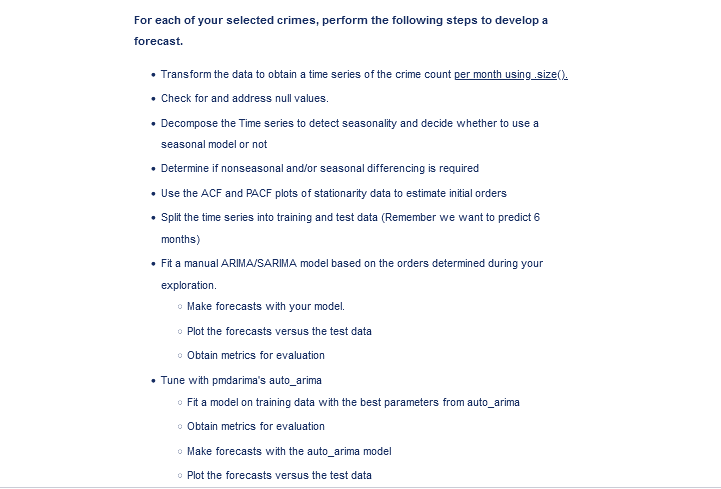

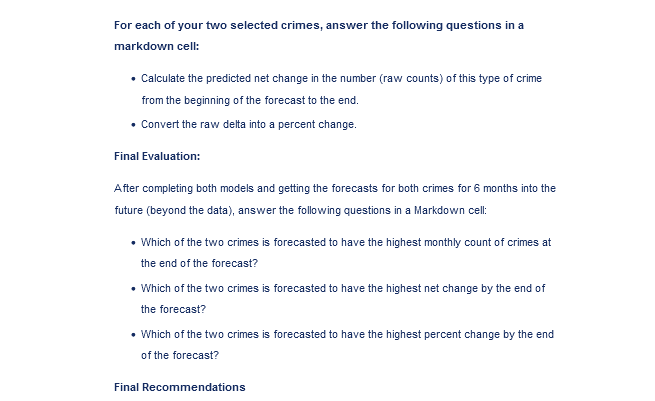

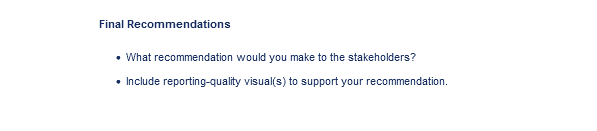

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7713109 entries, 2001-01-01 00:00:00 to 2022-12-31 23:55:00
Data columns (total 8 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Primary Type          object 
 1   Description           object 
 2   Location Description  object 
 3   Arrest                bool   
 4   Domestic              bool   
 5   Beat                  int64  
 6   District              float64
 7   year                  int32  
dtypes: bool(2), float64(1), int32(1), int64(1), object(3)
memory usage: 397.2+ MB


In [ ]:
df.head(

)

Primary Type                    Description  \
Date                                                                    
2001-01-01                       THEFT  FINANCIAL ID THEFT: OVER $300   
2001-01-01                       THEFT        AGG: FINANCIAL ID THEFT   
2001-01-01  OFFENSE INVOLVING CHILDREN  SEX ASSLT OF CHILD BY FAM MBR   
2001-01-01                       THEFT  FINANCIAL ID THEFT: OVER $300   
2001-01-01                Sexual Crime      AGG CRIMINAL SEXUAL ABUSE   

                         Location Description  Arrest  Domestic  Beat  \
Date                                                                    
2001-01-01                             STREET   False     False  2221   
2001-01-01                          RESIDENCE   False     False   812   
2001-01-01                          RESIDENCE   False     False  2124   
2001-01-01                          RESIDENCE   False     False   915   
2001-01-01  CHURCH/SYNAGOGUE/PLACE OF WORSHIP   False     False  1022   

            District  year  
Date                        
2001-01-01      22.0  2001  
2001-01-01       8.0  2001  
2001-01-01       2.0  2001  
2001-01-01       9.0  2001  
2001-01-01      10.0  2001

# Theft Modeling:

In [ ]:
ts_month_theft = df[df["Primary Type"] == "THEFT"].resample('MS').size()

In [ ]:
ts_month_theft.head()

Date
2001-01-01    7867
2001-02-01    6669
2001-03-01    7766
2001-04-01    7702
2001-05-01    8420
Freq: MS, dtype: int64

In [ ]:
ts_month_theft.isna().sum()

0

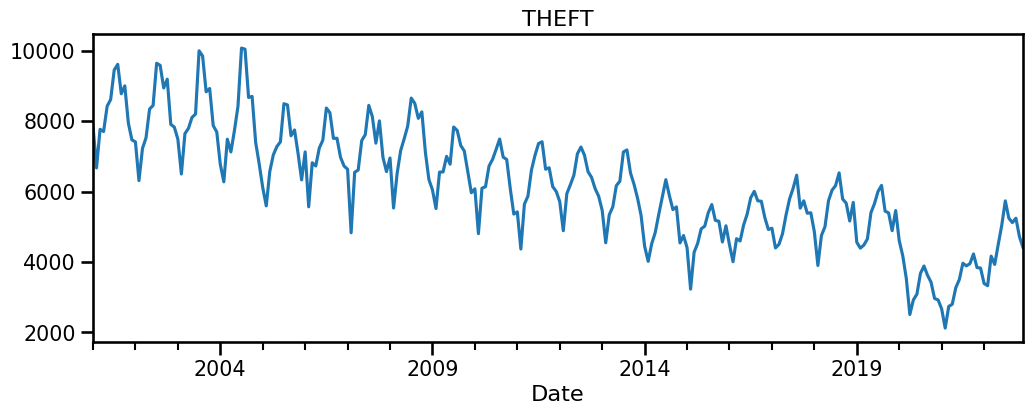

In [ ]:
ax = ts_month_theft.plot(title='THEFT')

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

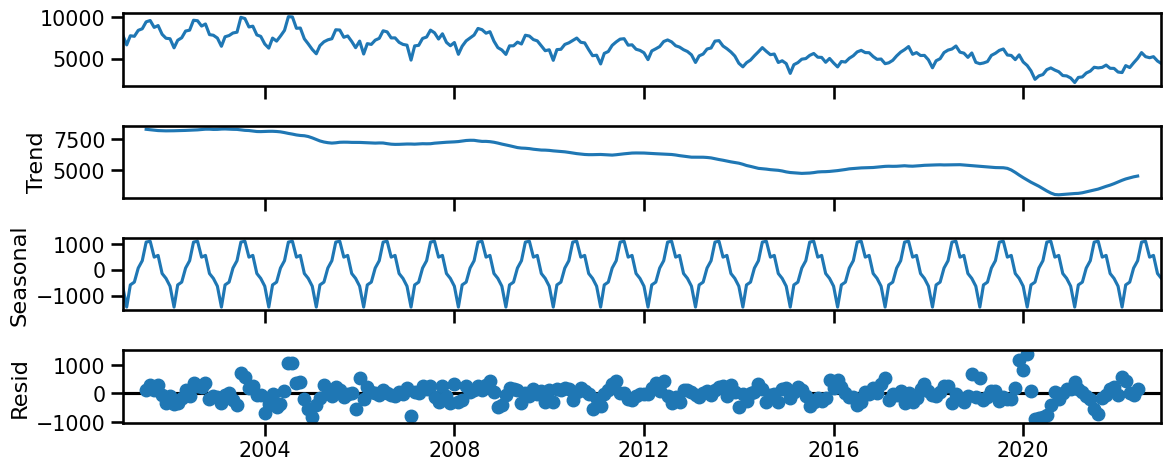

In [ ]:
# We see a repeating pattern that is likely seasonal
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts_month_theft)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

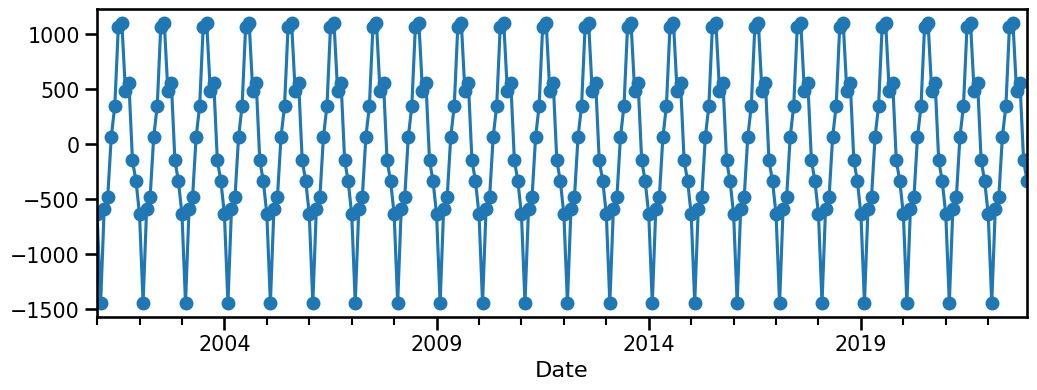

In [ ]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.plot(marker = 'o')

In [ ]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()
# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts_month_theft.max()-ts_month_theft.min()) * 100}% of the variation in time series.")


The seasonal component is 2549.988095238095 which is ~32.08339324657895% of the variation in time series.


In [ ]:
# determine d
d = ndiffs(ts_month_theft)
print (f'd = {d}')

d = 1


In [ ]:
# Determine D
D = nsdiffs(ts_month_theft, m =12)
print(f'D = {D}')

D = 0


Since D = 0 so we will apply only nonseasonal differencing

In [ ]:
get_adfuller_results(ts_month_theft, label='adfuller')

Test Statistic  # of Lags Used  # of Observations  p-value  alpha  \
adfuller       -1.393935              13                250  0.58518   0.05   

          sig/stationary?  
adfuller            False

The data is not stationary

In [ ]:
ts_diff=ts_month_theft.diff().dropna()
ts_diff

Date
2001-02-01   -1198.0
2001-03-01    1097.0
2001-04-01     -64.0
2001-05-01     718.0
2001-06-01     192.0
               ...  
2022-08-01    -490.0
2022-09-01    -127.0
2022-10-01     125.0
2022-11-01    -525.0
2022-12-01    -304.0
Freq: MS, Length: 263, dtype: float64

In [ ]:
get_adfuller_results(ts_diff)

Test Statistic  # of Lags Used  # of Observations   p-value  alpha  \
adfuller       -3.953728              12                250  0.001673   0.05   

          sig/stationary?  
adfuller             True

<Axes: title={'center': 'Differenced Time Series'}, xlabel='Date'>

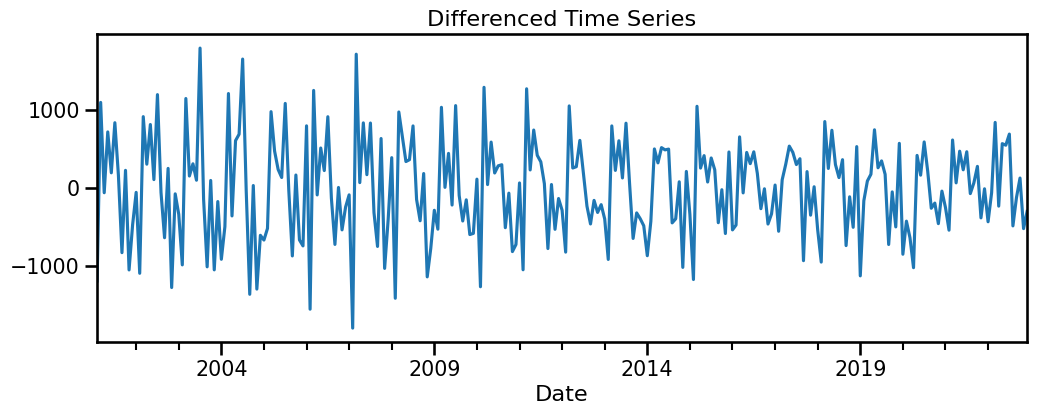

In [ ]:
ts_diff.plot(title='Differenced Time Series')

In [ ]:
# Determine differencing
d = ndiffs(ts_month_theft)
print(f'd is {d}')
D = nsdiffs(ts_month_theft, m =12)
print(f'D is {D}')


d is 1
D is 0


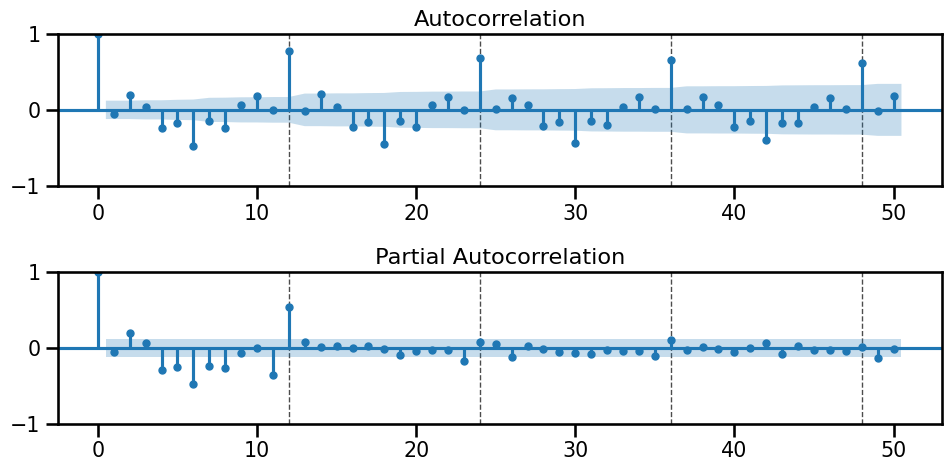

In [ ]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(ts_diff, annotate_seas = True, m = 12, nlags = 50);

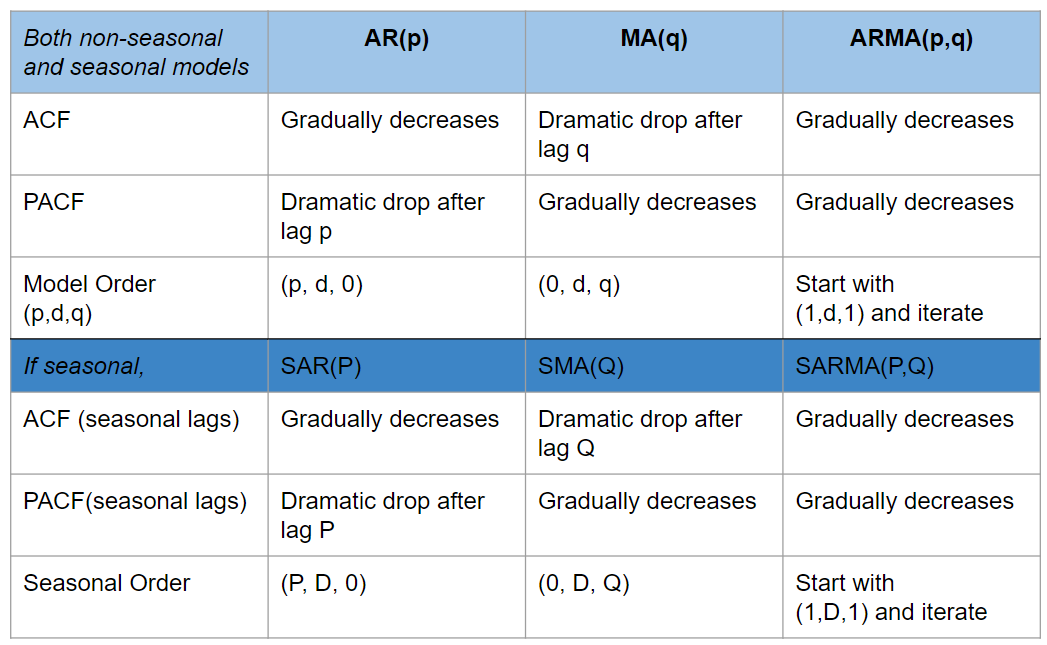

As we can see both the ACF and PACF are gradually decreasing in magnitude. So that starting with  AR(1) and MA(1)


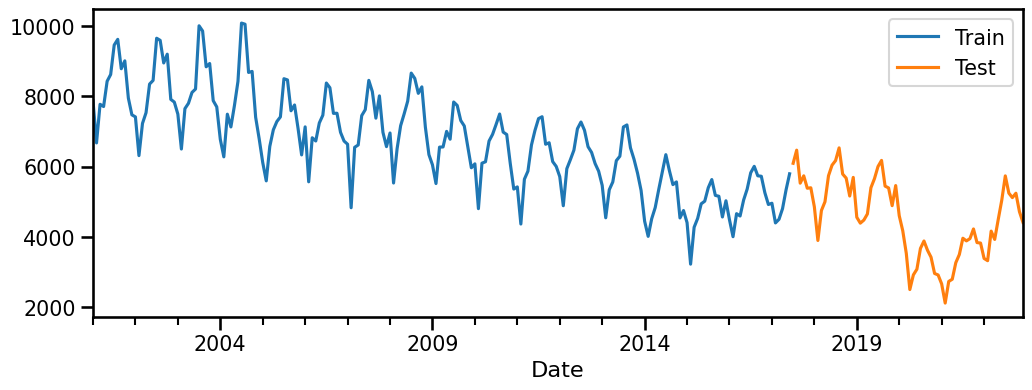

In [ ]:
# tts
train, test = train_test_split(ts_month_theft, test_size=.25)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [ ]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA
# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period
sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  198
Model:             ARIMA(1, 1, 1)x(1, 0, [], 12)   Log Likelihood               -1438.912
Date:                           Sat, 21 Dec 2024   AIC                           2885.824
Time:                                   16:30:40   BIC                           2898.957
Sample:                               01-01-2001   HQIC                          2891.140
                                    - 06-01-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6724      0.064     10.532      0.000       0.547       0.798
ma.L1         -0.9639      0.021    -44.961      0.000      -1.006      -0.922
ar.S.L12       0.8114      0.031     26.344      0.000       0.751       0.872
sigma2      1.115e+05   1.03e+04     10.852      0.000    9.13e+04    1.32e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.39   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.24   Prob(JB):                         0.75
Heteroskedasticity (H):               0.58   Skew:                            -0.05
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 952.980
- MSE = 1,633,666.850
- RMSE = 1,278.150
- R^2 = -0.346
- MAPE = 27.79%


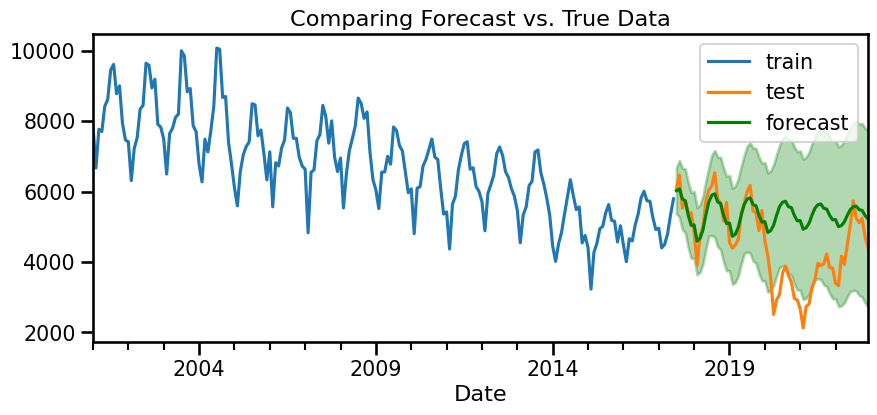

In [ ]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 952.980
- MSE = 1,633,666.850
- RMSE = 1,278.150
- R^2 = -0.346
- MAPE = 27.79%


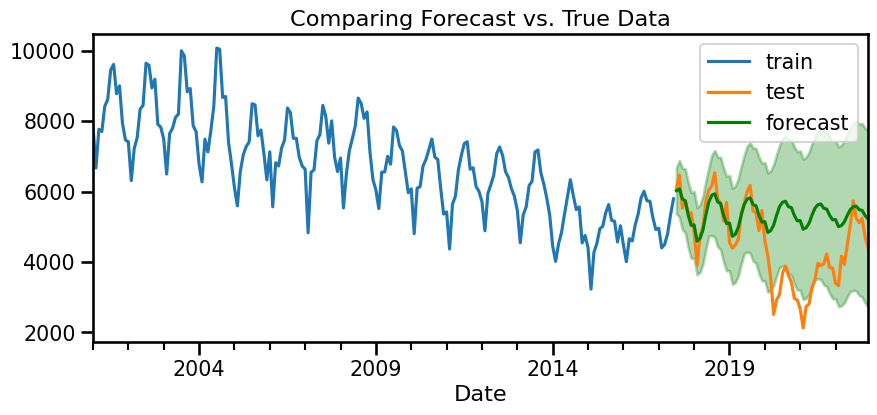

In [ ]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

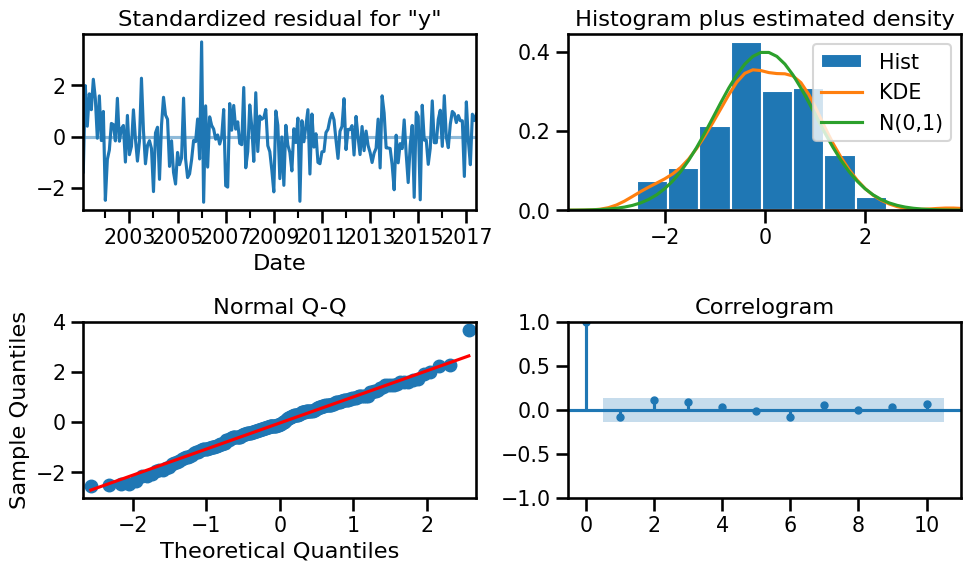

In [ ]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

**MAPE = 27.79%**

R^2 is negative that means the ARIMA model doesn't follow the trend of the data.

**Loop to try different orders**

In [ ]:
import itertools
# Define the value or range of values for p, d, q
p_values = range(0, 3)
d_values = [1]
q_values = range(0, 3)
P_values = range (0, 3)
D_values = [0]
Q_values = range (0,3)
m = [12]
# Create combinations of pdq to test
pdqPDQm_to_try = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m))
# Display first 10 combinations
pdqPDQm_to_try[:10]


[(0, 1, 0, 0, 0, 0, 12),
 (0, 1, 0, 0, 0, 1, 12),
 (0, 1, 0, 0, 0, 2, 12),
 (0, 1, 0, 1, 0, 0, 12),
 (0, 1, 0, 1, 0, 1, 12),
 (0, 1, 0, 1, 0, 2, 12),
 (0, 1, 0, 2, 0, 0, 12),
 (0, 1, 0, 2, 0, 1, 12),
 (0, 1, 0, 2, 0, 2, 12),
 (0, 1, 1, 0, 0, 0, 12)]

In [ ]:
# define starting aic as infinity
best_aic = float("inf")
# define baseline for pdq
best_pdqPDQm = (0,0,0,0,0,0,0)
# Loop through each combination
for pdqPDQm in pdqPDQm_to_try:
    order = pdqPDQm[:3] # first three values are non seasonal (p,d,q)
    seasonal_order = pdqPDQm[3:] # Remaining values for seasonal (P,D,Q,m)

    model = tsa.ARIMA(train, order=order, seasonal_order = seasonal_order)
    try:
        result = model.fit()
        print(pdqPDQm, result.aic)

    except:
        print(f'{pdqPDQm}: caused an error')

    # If lower, replace best AIC with new value
    if result.aic < best_aic:

        best_aic = result.aic
        best_pdqPDQm = pdqPDQm
# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdqPDQm:", best_pdqPDQm)



(0, 1, 0, 0, 0, 0, 12) 3126.0879297628926
(0, 1, 0, 0, 0, 1, 12) 3017.652269769742
(0, 1, 0, 0, 0, 2, 12) 2975.2949640187117
(0, 1, 0, 1, 0, 0, 12) 2911.2659968256703
(0, 1, 0, 1, 0, 1, 12) 2877.731591737892
(0, 1, 0, 1, 0, 2, 12) 2877.1441419247167
(0, 1, 0, 2, 0, 0, 12) 2896.862188844989
(0, 1, 0, 2, 0, 1, 12) 2877.627627777964
(0, 1, 0, 2, 0, 2, 12) 2878.5521320884327
(0, 1, 1, 0, 0, 0, 12) 3126.7652462730484
(0, 1, 1, 0, 0, 1, 12) 3015.394092729005
(0, 1, 1, 0, 0, 2, 12) 2970.6859811297472
(0, 1, 1, 1, 0, 0, 12) 2892.9043556665847
(0, 1, 1, 1, 0, 1, 12) 2856.666089522648
(0, 1, 1, 1, 0, 2, 12) 2855.9303108755657
(0, 1, 1, 2, 0, 0, 12) 2876.5694771874314
(0, 1, 1, 2, 0, 1, 12) 2856.438730780351
(0, 1, 1, 2, 0, 2, 12) 2863.6274112673063
(0, 1, 2, 0, 0, 0, 12) 3111.243113092418
(0, 1, 2, 0, 0, 1, 12) 3010.4670850489847
(0, 1, 2, 0, 0, 2, 12) 2968.2317544585353
(0, 1, 2, 1, 0, 0, 12) 2894.234566549338
(0, 1, 2, 1, 0, 1, 12) 2857.5722334071543
(0, 1, 2, 1, 0, 2, 12) 2856.6822220106224
(

# Best pdqPDQm: (0, 1, 1, 1, 0, 2, 12)


In [ ]:
# Orders for non seasonal components
p = 0 # nonseasonal AR
d = 1# nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 2 # Seasonal MA
m = 12 # Seasonal period

sarima1= tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                  198
Model:             ARIMA(0, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood               -1422.965
Date:                               Sat, 21 Dec 2024   AIC                           2855.930
Time:                                       16:33:26   BIC                           2872.346
Sample:                                   01-01-2001   HQIC                          2862.576
                                        - 06-01-2017                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3687      0.064     -5.800      0.000      -0.493      -0.244
ar.S.L12       0.9846      0.008    122.036      0.000       0.969       1.000
ma.S.L12      -0.5781      0.078     -7.455      0.000      -0.730      -0.426
ma.S.L24      -0.1275      0.089     -1.438      0.150      -0.301       0.046
sigma2      8.938e+04   8385.753     10.659      0.000    7.29e+04    1.06e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 5.95
Prob(Q):                              0.69   Prob(JB):                         0.05
Heteroskedasticity (H):               0.50   Skew:                            -0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 838.696
- MSE = 1,403,901.018
- RMSE = 1,184.863
- R^2 = -0.156
- MAPE = 24.41%


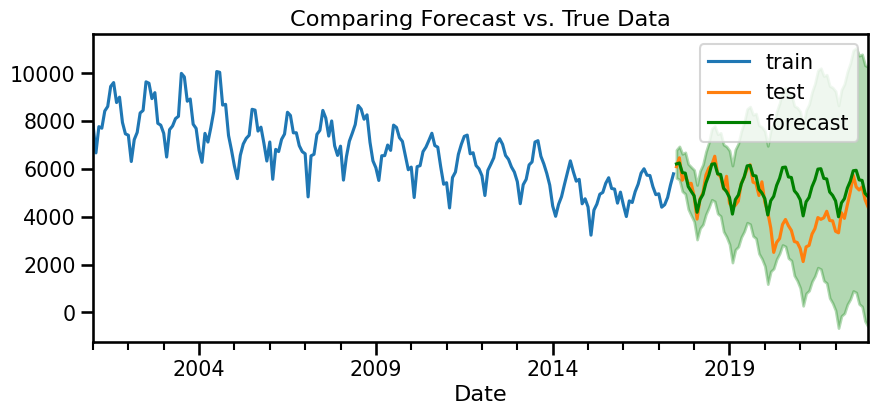

In [ ]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df1 = sarima1.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df1);
# Obtain metrics
regression_metrics_ts(test, forecast_df1['mean'])

This Model is performing better, it has lower MAE, MSE, RMSE and MAPE. This model has a higher R² (less negative) that means it explains more of the variation in the data.

# Auto Arima

In [ ]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3128.037, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2897.254, Time=0.45 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3017.305, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3126.088, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3128.164, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=4.19 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2861.575, Time=2.09 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3016.289, Time=0.33 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.22 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2861.049, Time=1.84 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2971.384, Time=1.18 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.50 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=2878.462, Time=3.84 sec
 ARIMA(2,1,0)(1,0,2)[12] intercept   : 

In [ ]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

(2, 1, 0)
(1, 0, 2, 12)


In [ ]:
# Obtain summary of the best model from auto_arima
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  198
Model:             SARIMAX(2, 1, 0)x(1, 0, [1, 2], 12)   Log Likelihood               -1423.345
Date:                                 Sat, 21 Dec 2024   AIC                           2860.690
Time:                                         16:34:28   BIC                           2883.673
Sample:                                     01-01-2001   HQIC                          2869.994
                                          - 06-01-2017                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.8871      2.037     -0.926      0.354      -5.880       2.106
ar.L1         -0.3333      0.070     -4.792      0.000      -0.470      -0.197
ar.L2         -0.1084      0.066     -1.651      0.099      -0.237       0.020
ar.S.L12       0.9842      0.009    115.065      0.000       0.967       1.001
ma.S.L12      -0.5755      0.078     -7.390      0.000      -0.728      -0.423
ma.S.L24      -0.1303      0.087     -1.497      0.134      -0.301       0.040
sigma2      9.005e+04   8701.406     10.349      0.000     7.3e+04    1.07e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.23
Prob(Q):                              0.96   Prob(JB):                         0.20
Heteroskedasticity (H):               0.50   Skew:                            -0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

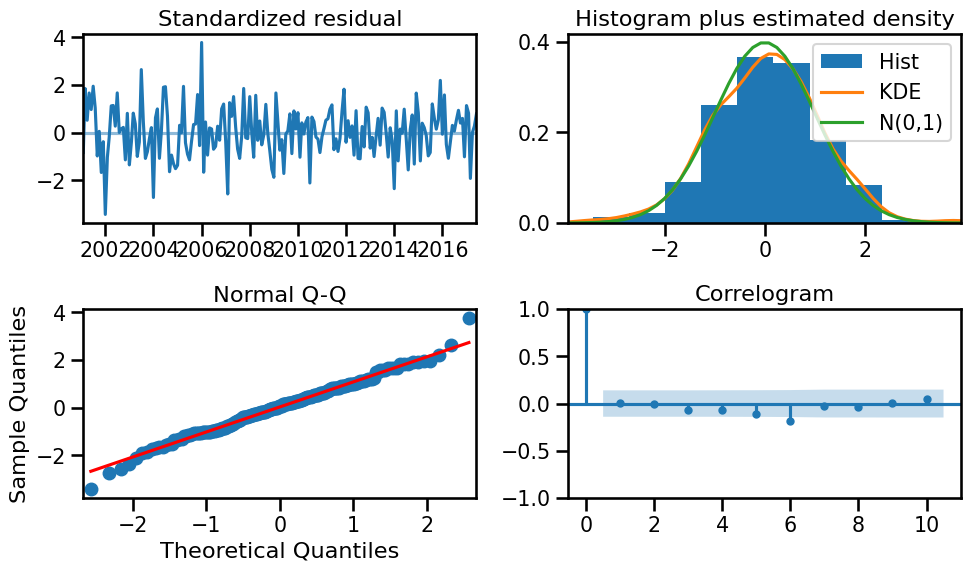

In [ ]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 809.736
- MSE = 1,327,393.850
- RMSE = 1,152.126
- R^2 = -0.093
- MAPE = 23.54%


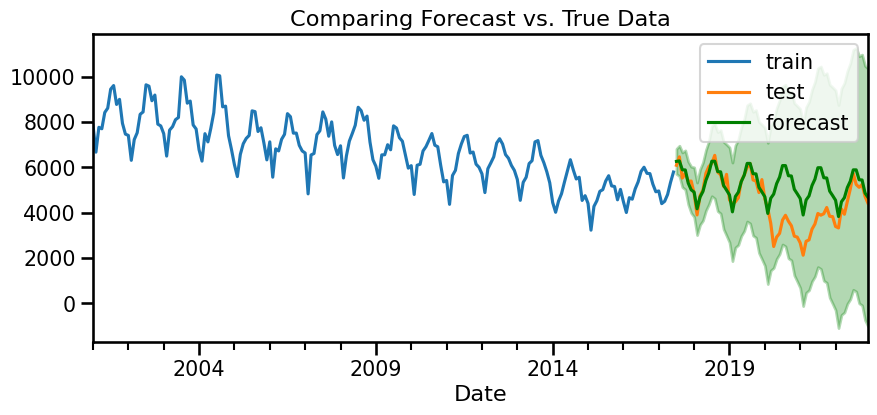

In [ ]:
# Use auto_arima parameters to fit an ARIMA
auto_model = tsa.ARIMA(
    train, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

This model is slightly better than the above models. In this model the MAPE is decreased from the above models to 23.54%.

# Choose the best model:

I chose the Auto Arima model based on MAPE since it is the lowest from other models and the digonistics of it is good.

# Make true future forecasts using the entire dataset (for dates beyond the entire ts).

ARIMA(2,1,0)(1,0,2)[12] intercept

In [ ]:
# Orders for non seasonal components
p = 2 # nonseasonal AR
d = 1# nonseasonal differencing
q = 0 # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 2 # Seasonal MA
m = 12 # Seasonal period

final_model= tsa.ARIMA(ts_month_theft, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()


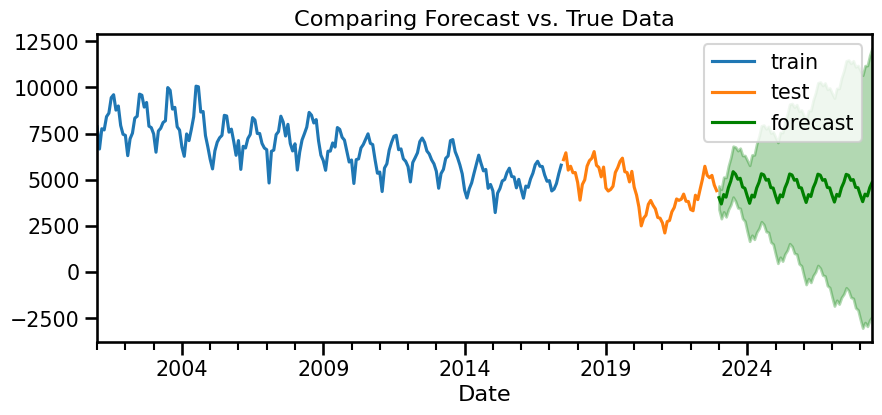

In [ ]:
# Obtain future forecasts beyond test data
forecast_df  = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df);

In [ ]:
forecast_df.index[0],forecast_df.index[-1]

(Timestamp('2023-01-01 00:00:00'), Timestamp('2028-06-01 00:00:00'))

In [ ]:
starting_value = forecast_df['mean'].iloc[0]
starting_value


4035.1256013925054

In [ ]:
final_value = forecast_df['mean'].iloc[-1]
final_value


4862.87123726261

In [ ]:
change = final_value - starting_value
change


827.7456358701043

In [ ]:
perc_change = (change / starting_value) * 100
perc_change


20.513503609019075

# Narcotics Modeling:

In [ ]:
df.head(20)

Primary Type                    Description  \
Date                                                                    
2001-01-01                       THEFT  FINANCIAL ID THEFT: OVER $300   
2001-01-01                       THEFT        AGG: FINANCIAL ID THEFT   
2001-01-01  OFFENSE INVOLVING CHILDREN  SEX ASSLT OF CHILD BY FAM MBR   
2001-01-01                       THEFT  FINANCIAL ID THEFT: OVER $300   
2001-01-01                Sexual Crime      AGG CRIMINAL SEXUAL ABUSE   
2001-01-01             CRIMINAL DAMAGE                     TO VEHICLE   
2001-01-01                Sexual Crime      AGG CRIMINAL SEXUAL ABUSE   
2001-01-01                Sexual Crime      AGG CRIMINAL SEXUAL ABUSE   
2001-01-01                       THEFT  FINANCIAL ID THEFT: OVER $300   
2001-01-01                       THEFT  FINANCIAL ID THEFT: OVER $300   
2001-01-01                Sexual Crime                 NON-AGGRAVATED   
2001-01-01                Sexual Crime      AGG CRIMINAL SEXUAL ABUSE   
2001-01-01                       THEFT  FINANCIAL ID THEFT: OVER $300   
2001-01-01                     ASSAULT                         SIMPLE   
2001-01-01                Sexual Crime      AGG CRIMINAL SEXUAL ABUSE   
2001-01-01                       THEFT        AGG: FINANCIAL ID THEFT   
2001-01-01                Sexual Crime                      PREDATORY   
2001-01-01                       THEFT        AGG: FINANCIAL ID THEFT   
2001-01-01                Sexual Crime          CRIMINAL SEXUAL ABUSE   
2001-01-01                Sexual Crime      AGG CRIMINAL SEXUAL ABUSE   

                         Location Description  Arrest  Domestic  Beat  \
Date                                                                    
2001-01-01                             STREET   False     False  2221   
2001-01-01                          RESIDENCE   False     False   812   
2001-01-01                          RESIDENCE   False     False  2124   
2001-01-01                          RESIDENCE   False     False   915   
2001-01-01  CHURCH/SYNAGOGUE/PLACE OF WORSHIP   False     False  1022   
2001-01-01                              OTHER   False     False  2411   
2001-01-01                          RESIDENCE   False     False   422   
2001-01-01  CHURCH/SYNAGOGUE/PLACE OF WORSHIP   False     False  1022   
2001-01-01                          RESIDENCE   False     False  1132   
2001-01-01                          RESIDENCE   False     False  1021   
2001-01-01                          RESIDENCE   False      True   421   
2001-01-01  CHURCH/SYNAGOGUE/PLACE OF WORSHIP   False     False  1022   
2001-01-01                              OTHER   False     False  2522   
2001-01-01                          APARTMENT   False      True  2433   
2001-01-01  CHURCH/SYNAGOGUE/PLACE OF WORSHIP   False     False  1022   
2001-01-01                              OTHER   False     False   835   
2001-01-01                          RESIDENCE   False      True   422   
2001-01-01                          RESIDENCE   False     False   621   
2001-01-01                          RESIDENCE   False     False   921   
2001-01-01  CHURCH/SYNAGOGUE/PLACE OF WORSHIP   False     False  1022   

            District  year  
Date                        
2001-01-01      22.0  2001  
2001-01-01       8.0  2001  
2001-01-01       2.0  2001  
2001-01-01       9.0  2001  
2001-01-01      10.0  2001  
2001-01-01      24.0  2001  
2001-01-01       4.0  2001  
2001-01-01      10.0  2001  
2001-01-01      11.0  2001  
2001-01-01      10.0  2001  
2001-01-01       4.0  2001  
2001-01-01      10.0  2001  
2001-01-01      25.0  2001  
2001-01-01      24.0  2001  
2001-01-01      10.0  2001  
2001-01-01       8.0  2001  
2001-01-01       4.0  2001  
2001-01-01       6.0  2001  
2001-01-01       9.0  2001  
2001-01-01      10.0  2001

In [ ]:
df['Primary Type'].value_counts()

Primary Type
THEFT                                1626992
BATTERY                              1410889
CRIMINAL DAMAGE                       878914
NARCOTICS                             746155
ASSAULT                               501103
OTHER OFFENSE                         479174
BURGLARY                              422246
MOTOR VEHICLE THEFT                   366586
DECEPTIVE PRACTICE                    340958
ROBBERY                               289677
CRIMINAL TRESPASS                     212869
Sexual Crime                          134129
WEAPONS VIOLATION                     103906
OFFENSE INVOLVING CHILDREN             55280
PUBLIC PEACE VIOLATION                 52086
INTERFERENCE WITH PUBLIC OFFICER       18206
LIQUOR LAW VIOLATION                   14846
GAMBLING                               14616
ARSON                                  13121
HOMICIDE                               12394
KIDNAPPING                              7185
STALKING                                4664
INTIMIDATION                            4595
CONCEALED CARRY LICENSE VIOLATION       1019
OBSCENITY                                810
NON-CRIMINAL                             228
PUBLIC INDECENCY                         193
OTHER NARCOTIC VIOLATION                 147
HUMAN TRAFFICKING                         96
RITUALISM                                 24
DOMESTIC VIOLENCE                          1
Name: count, dtype: int64

In [ ]:
ts_month_narcotics = df[df["Primary Type"] == "NARCOTICS"].resample('MS').size()

In [ ]:
ts_month_narcotics.head()

Date
2001-01-01    4714
2001-02-01    4369
2001-03-01    4862
2001-04-01    4044
2001-05-01    4038
Freq: MS, dtype: int64

In [ ]:
ts_month_narcotics.isna().sum()

0

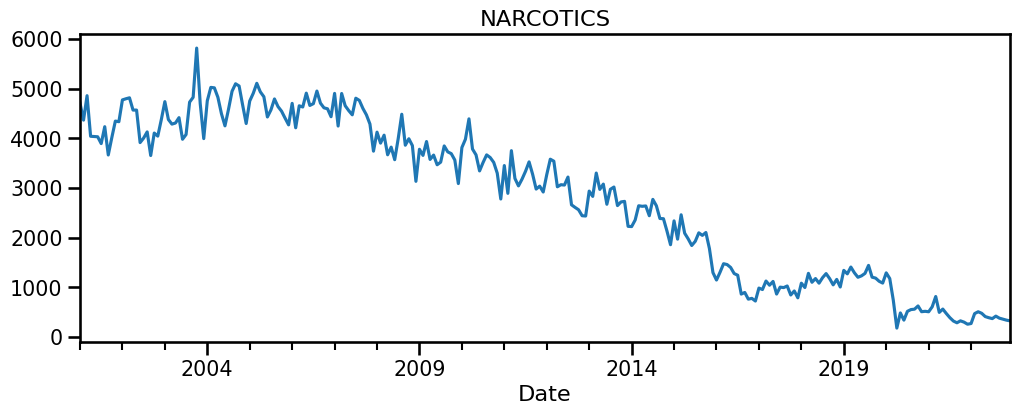

In [ ]:
ax = ts_month_narcotics.plot(title='NARCOTICS')

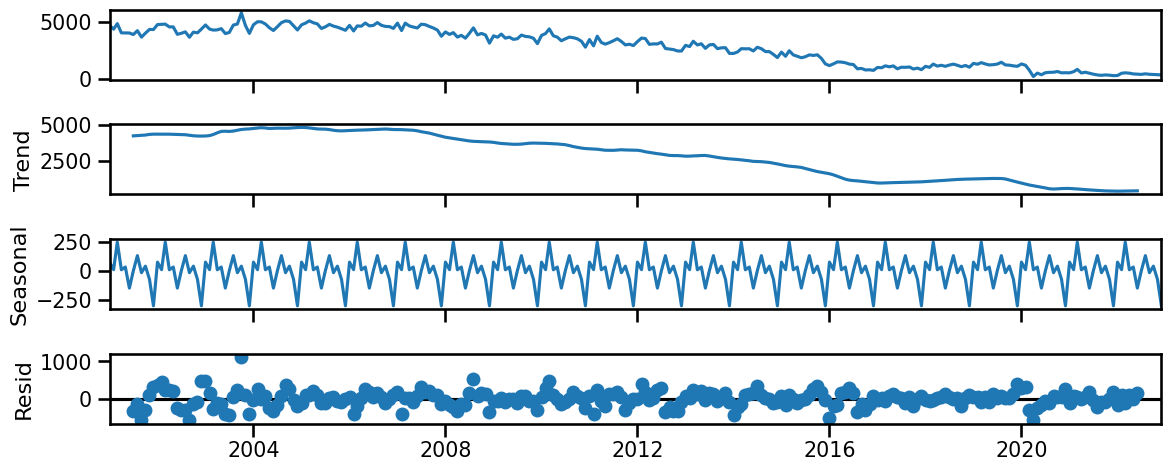

In [ ]:
# We see a repeating pattern that is likely seasonal
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts_month_narcotics)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [ ]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()
# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts_month_theft.max()-ts_month_theft.min()) * 100}% of the variation in time series.")


The seasonal component is 550.6626984126985 which is ~6.928317795831637% of the variation in time series.


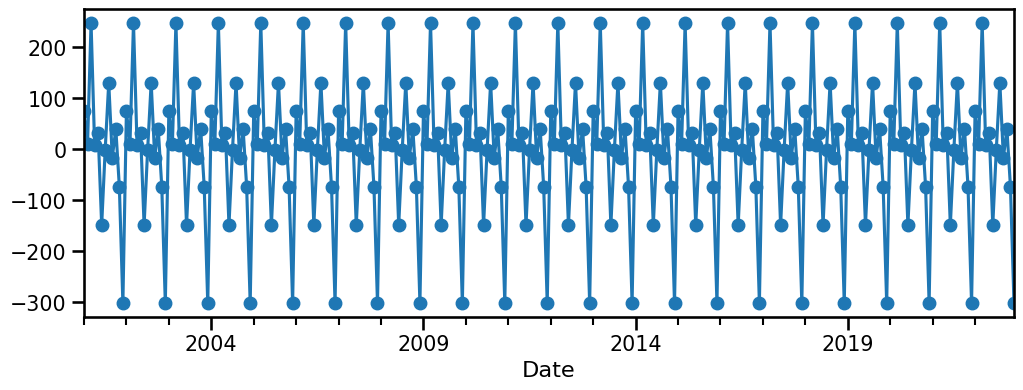

In [ ]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.plot(marker = 'o')

In [ ]:
# determine d
d = ndiffs(ts_month_narcotics)
print (f'd = {d}')

d = 1


In [ ]:
# Determine D
D = nsdiffs(ts_month_narcotics, m =12)
print(f'D = {D}')

D = 0


In [ ]:
get_adfuller_results(ts_month_narcotics, label='adfuller')

Test Statistic  # of Lags Used  # of Observations   p-value  alpha  \
adfuller        0.265472              12                251  0.975704   0.05   

          sig/stationary?  
adfuller            False

<Axes: xlabel='Date'>

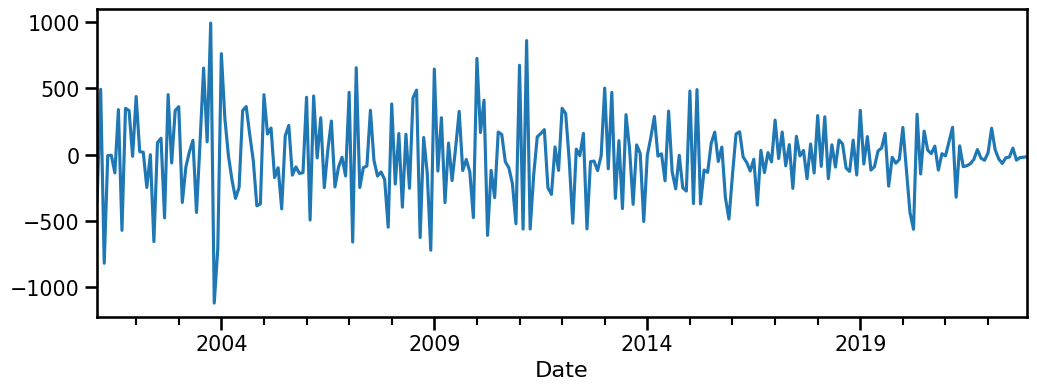

In [ ]:
ts_diff= ts_month_narcotics.diff().dropna()
ts_diff.plot()

<Axes: title={'center': 'Differenced Time Series'}, xlabel='Date'>

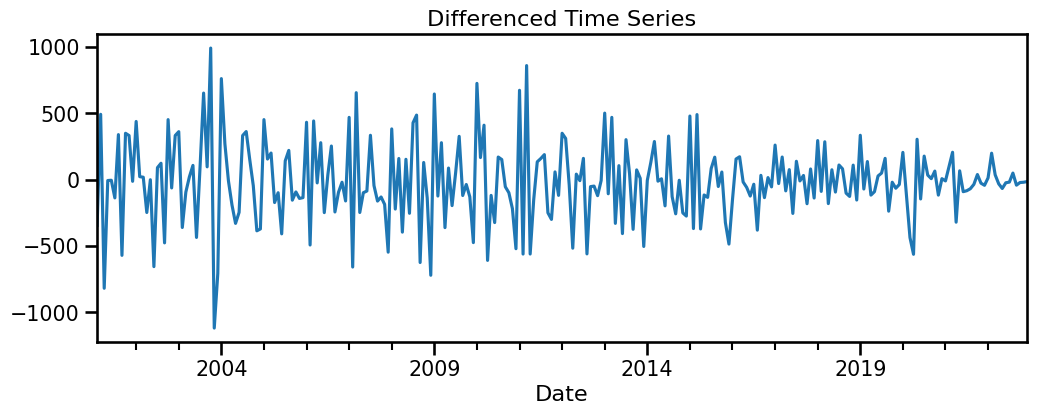

In [ ]:
ts_diff.plot(title='Differenced Time Series')

In [ ]:
get_adfuller_results(ts_diff)

Test Statistic  # of Lags Used  # of Observations   p-value  alpha  \
adfuller       -5.393766              11                251  0.000003   0.05   

          sig/stationary?  
adfuller             True

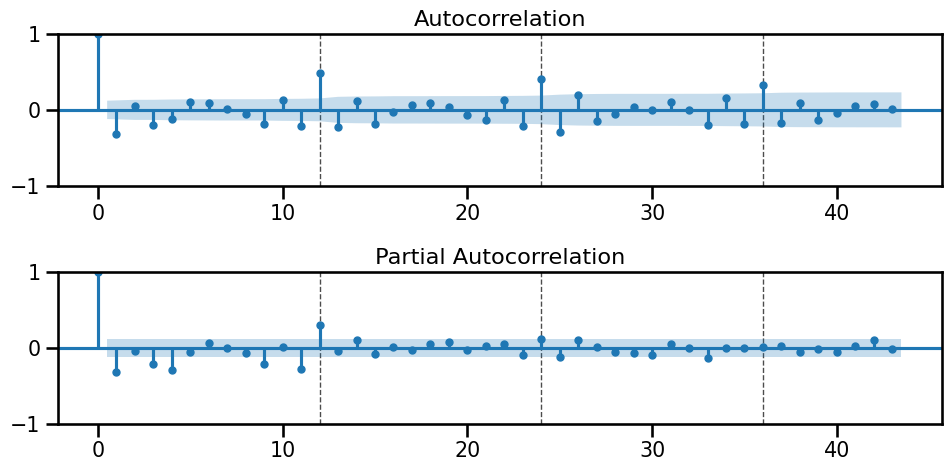

In [ ]:
# now look at the acf/pacf of the stationary data
plot_acf_pacf(ts_diff, annotate_seas = True, m = 12, nlags = 43);

In [ ]:
nlag= 6

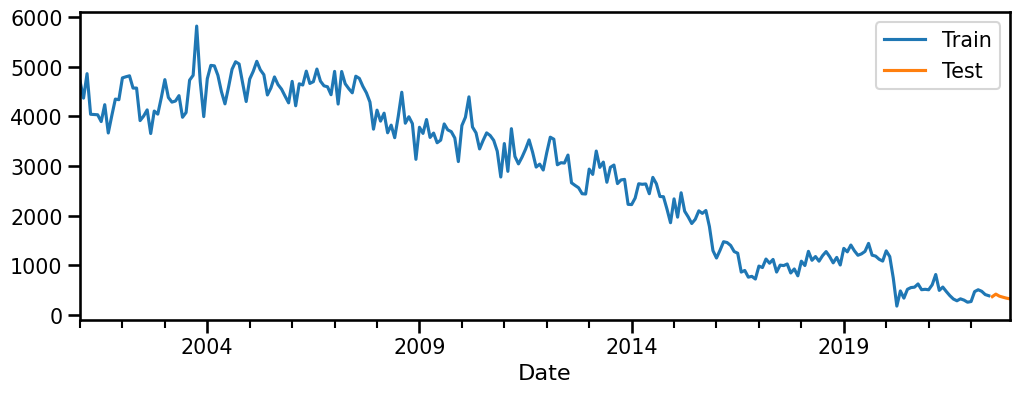

In [ ]:
# tts
train, test = train_test_split(ts_month_narcotics, test_size=6) # Assuming 'nlag' is meant to be test_size
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();
ax.legend();

In [ ]:
# Orders for non seasonal components
p = 0  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 0  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  258
Model:             ARIMA(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -1794.734
Date:                          Sat, 21 Dec 2024   AIC                           3595.469
Time:                                  16:34:44   BIC                           3606.116
Sample:                              01-01-2001   HQIC                          3599.751
                                   - 06-01-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4123      0.044     -9.303      0.000      -0.499      -0.325
ma.S.L12       0.3574      0.058      6.156      0.000       0.244       0.471
sigma2      6.802e+04   4467.872     15.224      0.000    5.93e+04    7.68e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):                38.29
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 48.602
- MSE = 3,063.779
- RMSE = 55.351
- R^2 = -2.300
- MAPE = 12.93%


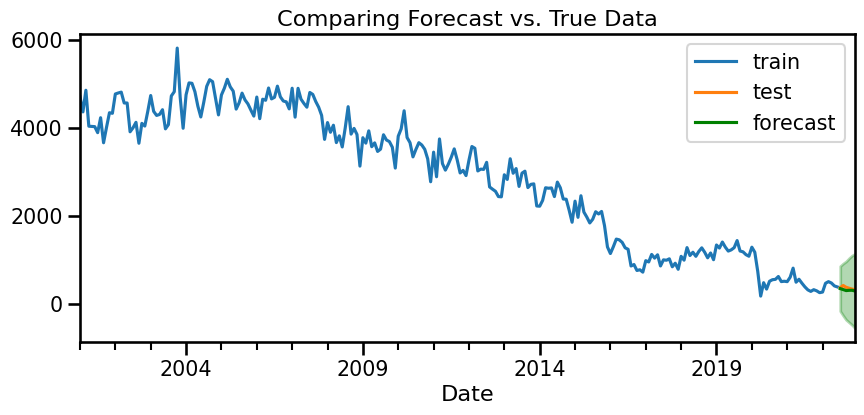

In [ ]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])